In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
from six.moves import urllib
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

'''Before running any code both sklearn and numpy must be installed.
To load and prepare '''

OPEN_LEARNING_PATH = os.path.join("datasets", "open_learning")
OPEN_LEARNING_URL = "https://analyse.kmi.open.ac.uk/open_dataset/download"

def fetch_courses_data(open_learning_url=OPEN_LEARNING_URL, open_learning_path=OPEN_LEARNING_PATH):
    ''' Downloads, unzips and saves all the tables/csv files provided by the open learning data set, with corresponding names'''
    if not os.path.isdir(open_learning_path):
        os.makedirs(open_learning_path)
    zip_path = os.path.join(open_learning_path, "anonymisedData.zip")
    urllib.request.urlretrieve(open_learning_url, zip_path)
    open_learning_zip = zipfile.ZipFile(zip_path)
    open_learning_zip.extractall(path=open_learning_path)
    open_learning_zip.close()


def load_courses_data(data_path=OPEN_LEARNING_PATH):
    '''Loads the data for the courses table, stored in the file courses.csv, and stores it in a pandas dataframe'''
    csv_path = os.path.join(data_path, "courses.csv")
    return pd.read_csv(csv_path)


def load_studentInfo_data(data_path=OPEN_LEARNING_PATH):
    '''Loads the data for the studentInfo table, stored in the file studentInfo.csv, and stores it in a pandas dataframe'''
    csv_path = os.path.join(data_path, "studentInfo.csv")
    return pd.read_csv(csv_path)

def load_studentVle_data(data_path=OPEN_LEARNING_PATH):
    '''Loads the data for the studentVle table, stored in the file studentVle.csv, and stores it in a pandas dataframe'''
    csv_path = os.path.join(data_path, "studentVle.csv")
    return pd.read_csv(csv_path)


def load_assessments_data(data_path=OPEN_LEARNING_PATH):
    '''Loads the data for the assessments table, stored in the file assessments.csv, and stores it in a pandas dataframe'''
    csv_path = os.path.join(data_path, "assessments.csv")
    return pd.read_csv(csv_path)


def load_studentAssessment_data(data_path=OPEN_LEARNING_PATH):
    '''Loads the data for the studentAssessments table, stored in the file studentAssessments.csv, and stores it in a pandas dataframe'''
    csv_path = os.path.join(data_path, "studentAssessment.csv")
    return pd.read_csv(csv_path)


def load_studentRegistration_data(data_path=OPEN_LEARNING_PATH):
    '''Loads the data for the studentRegistration table, stored in the file studentRegistration.csv, and stores it in a pandas dataframe'''
    csv_path = os.path.join(data_path, "studentRegistration.csv")
    return pd.read_csv(csv_path)


def load_vle_data(data_path=OPEN_LEARNING_PATH):
    '''Loads the data for the vle table, stored in the file vle.csv, and stores it in a pandas dataframe'''
    csv_path = os.path.join(data_path, "vle.csv")
    return pd.read_csv(csv_path)

def split_data(studentInfo_data):
    '''Uses stratified sampling on the previously highest education level of a student to split the studentInfo table into a
    train(80%) and test(20%) set. Sets 'random_state' to be 42, ensuring that the split is exactly the same each time the dataset is loaded.'''
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(studentInfo_data, studentInfo_data["highest_education"]):
        strat_train_set = studentInfo_data.loc[train_index]
        strat_test_set = studentInfo_data.loc[test_index]
    return strat_train_set, strat_test_set

def calc_tma_per():
    '''Although not used as one of the final features, calculates the percentage of each module presentation that is assesed with teacher
    marked assessments'''
    module_data = pd.DataFrame(columns=["code_module", "code_presentation", "per_TMA"])
    for index, mod in courses_data.iterrows():
        mod_ass = assessment_data.loc[mod["code_module"] == assessment_data["code_module"]]
        mod_ass = mod_ass.loc[mod["code_presentation"] == mod_ass["code_presentation"]]
        tma = mod_ass.loc["TMA" == mod_ass["assessment_type"]]["weight"].sum()
        all_der = pd.DataFrame(data={"code_module": [mod["code_module"]], "code_presentation": [mod["code_presentation"]], "per_TMA": [tma]})
        module_data = pd.concat([module_data, all_der], ignore_index=True)
    return module_data

def calc_relevant_sites(num_sites):
    '''Identifies a certain number of the resources (sepcified by num_sites) that have the most total clicks, given that they were only visited 
    by less than the average number of students per presentation. Creates a new column for each of these most popular resources in the studentInfo 
    dataframe, the values of which are the number of times a student has clicked on that resource.'''
    
    relevant_sites = pd.DataFrame(columns=["id_site", "num_students", "clicks_per_site"])
    student_per_pres = pd.DataFrame(columns = ["code_module", "code_presentation", "no_students"])
    
    # Reduce to table that only contains sites not visited by everyone in a presentation but visited frequently by those that do visit them
    # Frequently being more than 6 times
    # First find number of students per presentation
    
    for index, mod in courses_data.iterrows():
        mod_ass = studentInfo_data.loc[mod["code_module"] == studentInfo_data["code_module"]]
        mod_ass = mod_ass.loc[mod["code_presentation"] == mod_ass["code_presentation"]]
        all_der = pd.DataFrame(data={"code_module": [mod["code_module"]], "code_presentation": [mod["code_presentation"]], "no_students": [len(mod_ass)]})
        student_per_pres = pd.concat([student_per_pres, all_der], ignore_index=True)
        
    avg_student_per_pres = student_per_pres["no_students"].mean()
    
    for index, mod in vle_data.iterrows():
        mod_vle = student_vle_data.loc[mod["id_site"] == student_vle_data["id_site"]]
        num_clicks = mod_vle["sum_click"].sum()
        mod_vle = mod_vle.drop_duplicates(["id_student", "code_module", "code_presentation"], keep="first")
        if len(mod_vle) < avg_student_per_pres and num_clicks>1000:
            all_der = pd.DataFrame(data={"id_site": [mod["id_site"]], "num_students": [len(mod_vle)], "clicks_per_site": num_clicks})
            relevant_sites = pd.concat([relevant_sites, all_der], ignore_index = True)

    relevant_sites = relevant_sites.sort_values(by="clicks_per_site", ascending=False)
    site_names = [site for site in relevant_sites.head(num_sites)["id_site"]]
    return pd.DataFrame(columns=["id_student", "code_module", "code_presentation"]+site_names)
        
class LabelBinarizer(TransformerMixin):
    '''Utilises scikit learns MultiLabelBianrizer such that categorical attributes that are fitted are first converted into integer representations,
    these are then one hot encoded to prevent any inference of association between similar values'''
    def __init__(self, *args, **kwargs):
        self.encoder = MultiLabelBinarizer(*args, **kwargs)
        
    def fit(self, x, y=None):
        self.encoder.fit(x)
        return self
    
    def transform(self, x, y=None):
        return self.encoder.transform(x)
    
class final_selector(BaseEstimator, TransformerMixin):
    '''Used to select the final numerical and categorical attributes that will be used for input by dropping those not needed'''
    def __init__(self, to_drop):
        self.to_drop = to_drop
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        final_attribs = list(set(X[1]) - set(self.to_drop))
        X = pd.DataFrame(X[0], columns = X[1])
        return X[final_attribs].values
    
class custom_imputer(BaseEstimator, TransformerMixin):
    '''Used to fill in missing imd band values in the data set. Does this using the median imd band for the instances corresponing 
    region'''
    def __init__(self, attribs, method = "median"):
        self.method = method
        self.attribs = attribs
        self.imd_bands = ["{}-{}%".format(x, x+10) for x in range(0, 100, 10)]
        self.imd_ranks = dict(zip(self.imd_bands, range(len(self.imd_bands))))
        self.imd_avgs = {}
        
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.DataFrame(X, columns = self.attribs)
        missing_imd = X.isnull().any(axis=1)
        X["imd_band_rank"] = X["imd_band"].map(self.imd_ranks)
        for index, stu in X[missing_imd].iterrows():
            if stu["imd_band"] not in self.imd_bands:
                    if stu["region"] not in self.imd_avgs.keys():
                        region = X.loc[X["region"] == stu["region"]].dropna()
                        region_ranked = region.sort_values(['imd_band_rank'])
                        X.loc[index, "imd_band"] = region_ranked.reset_index()["imd_band"][len(region_ranked)//2]
                        self.imd_avgs[stu["region"]] = X["imd_band"][index]
                    else:
                        X.loc[index, "imd_band"] = self.imd_avgs[stu["region"]]
        X = X.drop("imd_band_rank", axis=1)
        X["imd_band"] = X["imd_band"].astype(str)
        return X.values, X.columns
    
class unique_attributes_adder(BaseEstimator, TransformerMixin):
    '''Used to add atributes found in other tables, those being the percentage of assessments that are
    teacher marked for a module presentation and duration of each module presentation'''
    def __init__(self, attribs, next_attribs):
        self.attribs = attribs
        self.next_attribs = next_attribs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.DataFrame(X, columns = self.attribs)
        if 'per_TMA' in self.next_attribs:
            per_tma = calc_tma_per()
            X = pd.merge(X, per_tma, on=['code_module', 'code_presentation'], how='outer')
        if 'module_presentation_length' in self.next_attribs:
            X = pd.merge(X, courses_data, on=['code_module', 'code_presentation'], how='outer')
        return X.values
    
class derived_attributes_adder(BaseEstimator, TransformerMixin):
    '''Adds numerical attributes, that are derived from others, to the table. These include the average time between which a student makes 
    a click, the total number of clicks made by a student, the number of different resources that a student visits and the number of clicks
    a student makes on each of the top sites(identified by 'calc_relevant_sites')'''
    def __init__(self, attribs, next_attribs, top_sites=20):
        self.attribs = attribs
        self.new_attribs = list(set(next_attribs) - set(attribs))
        self.top_sites = top_sites
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.DataFrame(X, columns = self.attribs)
        der_data = pd.DataFrame()
        
        if 'clicks_per_site' in self.new_attribs:
            site_names = calc_relevant_sites(self.top_sites)
            
        for index, mod in X.iterrows():
            new_values = {"id_student": mod["id_student"], "code_module": mod["code_module"], "code_presentation": mod["code_presentation"]}
            stu_tbl = student_vle_data.loc[student_vle_data["id_student"] == mod["id_student"]]
            stu_tbl = stu_tbl.loc[stu_tbl["code_module"] == mod["code_module"]]
            stu_tbl = stu_tbl.loc[stu_tbl["code_presentation"] == mod["code_presentation"]]
            ord_stu = stu_tbl.sort_values(by="date")
            
            if 'avg_time' in self.new_attribs:
                new_values['avg_time'] = [ord_stu["date"].diff().mean()]
                if np.isnan(new_values['avg_time']):
                    avg_dif = courses_data.loc[(courses_data['code_module'] == mod["code_module"]) & (courses_data['code_presentation'] == mod["code_presentation"])]
                    new_values['avg_time'] = [avg_dif.reset_index().at[0,"module_presentation_length"]]
                    
            if 'all_clicks' in self.new_attribs:
                new_values['all_clicks'] = [stu_tbl["sum_click"].sum()]
                
            if 'all_sites' in self.new_attribs:
                new_values['all_sites'] = [len(stu_tbl.drop_duplicates(subset="id_site", keep="first"))]
                
            if 'clicks_per_site' in self.new_attribs:
                for site in site_names.columns:
                    if type(site) == int:
                        new_values[str(site)] = [stu_tbl.loc[stu_tbl["id_site"] == site]["sum_click"].sum()]
                    
            all_der = pd.DataFrame.from_dict(new_values)
            if der_data.empty:
                der_data = pd.DataFrame.from_dict(new_values)
            else:
                der_data = pd.concat([der_data,  all_der], ignore_index=True)
        X = pd.merge(X, der_data, on=["id_student", "code_module", "code_presentation"], how='outer')
        return X.values, X.columns
            
'''Load in all the needed data provided by open learning'''
courses_data = load_courses_data()
assessment_data = load_assessments_data()
studentInfo_data = load_studentInfo_data()
student_vle_data = load_studentVle_data()
vle_data = load_vle_data()

'''Split the data into a test and train set'''
studentInfo_train, studentInfo_test = split_data(studentInfo_data)

'''Split the training and test data into respective input and output features'''
full_data = studentInfo_train.drop("final_result", axis=1)
full_results = pd.DataFrame(studentInfo_train["final_result"].values, columns=["final_result"])
test_data = studentInfo_test.drop("final_result", axis=1)
test_results = pd.DataFrame(studentInfo_test["final_result"].values, columns=["final_result"])

'''Specify features that will originally be included, allowing for others to be derived'''
init_attribs = list(full_data.columns)
cat_attribs = ["code_module", "code_presentation", "highest_education", "gender", "region", "imd_band", "age_band", "disability"]
num_attribs = list(set(list(init_attribs))-set(cat_attribs))

'''Specify what derived features should actually be added'''
uniq_attribs = init_attribs + []#'per_TMA', 'module_presentation_length'
der_attribs = uniq_attribs + ['all_clicks', 'clicks_per_site', 'avg_time', 'all_sites']

'''Specify what features must be removed, and in those that will be used, once the data has been fully processed'''
to_drop = ['gender', 'region']
num_to_drop = to_drop + cat_attribs
cat_to_drop = to_drop + num_attribs
#final_attribs = list(set(der_attribs) - set(to_drop))
#final_cat_attribs = list(set(final_attribs) & set(init_cat_attribs))
#final_num_attribs = list(set(final_attribs) & set(init_num_attribs))

'''Pipeline for the processing of numerical data derives and selects attributes that  will be used, then standardises these using
sklearns standScaler'''
num_pipeline = Pipeline([('uniq_attribs_adder', unique_attributes_adder(init_attribs, uniq_attribs)),
                         ('der_attribs_adder', derived_attributes_adder(uniq_attribs, der_attribs)),
                         ('final_selector', final_selector(num_to_drop)),
                         ('scaler', StandardScaler()),
                        ])

'''Pipeline for the processing of categorical attributes, imputes missing values in the data set, selects the attributes to be used 
and then one hot encodes the categories using sklearns LabelBinarizer'''
cat_pipeline = Pipeline([('imputer', custom_imputer(init_attribs)),
                         ('final_selector', final_selector(cat_to_drop)),
                         ('cat_binarizer', LabelBinarizer()),
                        ])

'''Pipeline that is responsible for joining the outputs of both the number and category pipelines, giving a table of the fully prepared input data'''
full_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline),
                                               ("cat_pipeline", cat_pipeline),
                                              ])

prepared_data = full_pipeline.fit_transform(full_data.values)
prepared_test_data = full_pipeline.fit_transform(test_data.values)
prepared_data


array([[-0.07128124,  0.24831616, -0.12749809, ...,  0.        ,
         0.        ,  0.        ],
       [-0.07128124,  0.97788914, -0.12749809, ...,  0.        ,
         0.        ,  1.        ],
       [-0.07128124,  3.89618107, -0.12749809, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.07128124, -0.48125683, -0.12749809, ...,  0.        ,
         0.        ,  0.        ],
       [-0.07128124,  0.97788914, -0.12749809, ...,  0.        ,
         0.        ,  0.        ],
       [-0.07128124, -0.48125683, -0.12749809, ...,  0.        ,
         0.        ,  0.        ]])

In [66]:
full_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26074 entries, 19938 to 15358
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           26074 non-null  object
 1   code_presentation     26074 non-null  object
 2   id_student            26074 non-null  int64 
 3   gender                26074 non-null  object
 4   region                26074 non-null  object
 5   highest_education     26074 non-null  object
 6   imd_band              25166 non-null  object
 7   age_band              26074 non-null  object
 8   num_of_prev_attempts  26074 non-null  int64 
 9   studied_credits       26074 non-null  int64 
 10  disability            26074 non-null  object
dtypes: int64(3), object(8)
memory usage: 2.4+ MB


In [28]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone

def validate_and_scores(classifier, in_data, res_data, fit_data = False):
    '''Carries out 10 fold cross validation on input classifier, handles cases where the data used to fit 
    the first classifier is the same as that used to fit the second and where it is not'''
    if type(fit_data) != bool:
        skfolds = StratifiedKFold(n_splits=10, random_state=42)
        total_score = 0
        for train_index, test_index in skfolds.split(in_data, res_data):
            clone_clf = clone(classifier)
            in_train_folds = in_data[train_index]
            fit_train_folds = fit_data[train_index]
            out_train_folds = (res_data[train_index])
            in_test_fold = in_data[test_index]
            out_test_fold = (res_data[test_index])
            clone_clf.fit(in_train_folds, fit_train_folds)
            clf_predict = clone_clf.predict(in_test_fold)
            n_correct = sum(clf_predict == out_test_fold)
            total_score += n_correct / len(clf_predict)
        average = total_score/10
        
    else:
        scores = cross_validate(classifier, in_data, res_data, scoring=("accuracy"), cv=10)#, "average_precision", "recall"
        average = scores["test_score"].mean()
    print("Means:", "Accuracy: ", average)#, '\nPrescision: ', scores["test_average_precision"].mean())
    return average
    

def parameter_search(classifier, in_data, res_data, params_1, params_2, fit_data = False):
    '''Given a set of possible parameters for each classifier, performs grid search on both as a whole. Uses validate_and_scores
    function to assess the accuracy of each combination of parameters'''
    best_score = 0
    all_comb = {"grid_1": list(ParameterGrid(params_1)), "grid_2": list(ParameterGrid(params_2))}
    for params in ParameterGrid(all_comb):
        clone_clf = clone(classifier)
        clone_clf.set_params(params)
        score = validate_and_scores(clone_clf, in_data, res_data, fit_data)
        if score > best_score:
            best_score = score.copy()
            best_grid = params
            
    print("Best score and grid: " + str(best_score) + "  " + str(best_grid))

        
    
    #print(scores)
    #print("Scores:", scores["test_score"])#, '\n', scores["test_average_precision"])
    #print(scores["test_recall"])
    #print("Recall: ", scores["test_recall"].mean())

In [14]:

pass_res = full_results.loc[full_results["final_result"] == "Pass"].copy()
dis_res = full_results.loc[full_results["final_result"] == "Distinction"].copy()
fail_res = full_results.loc[full_results["final_result"] == "Fail"].copy()
with_res = full_results.loc[full_results["final_result"] == "Withdrawn"].copy()


'''Classes to Pass/Fail(1/0)'''
pass_res["final_result"], dis_res["final_result"] = 1, 1
fail_res["final_result"], with_res["final_result"] = 0, 0

binary_results = pd.concat([pass_res, fail_res, dis_res, with_res], ignore_index=False).sort_index()

'''Classes to Pass/Fail/Withdrawn/Distinction'''
pass_res["final_result"], dis_res["final_result"] = 1, 2
fail_res["final_result"], with_res["final_result"] = 3, 4

four_class_results = pd.concat([pass_res, fail_res, dis_res, with_res], ignore_index=False).sort_index()

'''Logistic Regression'''

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
#log_reg.fit(prepared_data, binary_results.values.ravel())

validate_and_scores(log_reg, prepared_data, binary_results.values.ravel())
    
'''SGD Classifier'''
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
#sgd_clf.fit(prepared_data, binary_results.values.ravel())

validate_and_scores(sgd_clf, prepared_data, binary_results.values.ravel())

'''Naive Bayers Classifier'''
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
#gnb_clf.fit(prepared_data, binary_results.values.ravel())

validate_and_scores(gnb_clf, prepared_data, binary_results.values.ravel())

'''SVM Classifier Linear'''
from sklearn.svm import LinearSVC
svm_lin_clf = LinearSVC(C=1, loss="hinge", max_iter=100000)
#svm_lin_clf.fit(prepared_data, binary_results.values.ravel())

validate_and_scores(svm_lin_clf, prepared_data, binary_results.values.ravel())

'''SVM Classifier Non-Linear'''
from sklearn.preprocessing import PolynomialFeatures
svm_non_clf = LinearSVC(C=10, loss="hinge")
#svm_non_clf.fit(prepared_data, binary_results.values.ravel())

validate_and_scores(svm_non_clf, prepared_data, binary_results.values.ravel())


/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

Means: Accuracy:  0.8414894655964005
Means: Accuracy:  0.838804489917424
Means: Accuracy:  0.6840527126118684


/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

Means: Accuracy:  0.8447877764207267


/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

Means: Accuracy:  0.8446727163300316


/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [70]:

from sklearn.model_selection import cross_val_predict
predicts = pd.DataFrame(cross_val_predict(svm_lin_clf, prepared_data, binary_results.values.ravel()))

/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

In [72]:
predicts.head()

,0
0,1
1,0
2,0
3,0
4,1


In [5]:
'''Initial Random Forests Classification'''
from sklearn.ensemble import RandomForestClassifier

ran_for_reg = RandomForestClassifier(n_estimators=100)
ran_for_reg.fit(prepared_data, binary_results.values.ravel())
print(ran_for_reg.feature_importances_)

validate_and_scores(ran_for_reg, prepared_data, binary_results.values.ravel())



[0.00510253 0.00558991 0.00335764 0.00598072 0.01243473 0.00586595
 0.00847985 0.00448049 0.02242154 0.00430639 0.05102027 0.13749066
 0.01273145 0.00389561 0.0023476  0.00732993 0.0049227  0.00794682
 0.00428001 0.00532147 0.00385168 0.00453648 0.22198595 0.26595505
 0.00563211 0.00496415 0.00617876 0.00640362 0.00561427 0.00549189
 0.00334189 0.00526349 0.00410942 0.00628034 0.00557545 0.00656711
 0.00524582 0.00495702 0.00058256 0.00492444 0.00478607 0.00493264
 0.00443901 0.00613822 0.00249428 0.01316859 0.00487007 0.00617822
 0.00389762 0.02109722 0.01021468 0.00448506 0.01080048 0.00410564
 0.00115788 0.00072686 0.00373968]
{'fit_time': array([3.59496212, 3.53303742, 3.68860793, 3.07335734, 3.0255425 ,
       2.89179206, 2.79662538, 2.80930924, 3.26729441, 3.01835322]), 'score_time': array([0.0601306 , 0.05910492, 0.05989957, 0.05961561, 0.06177878,
       0.05629945, 0.05424786, 0.05826211, 0.06035876, 0.05849409]), 'test_score': array([0.86886503, 0.87193252, 0.89110429, 0.8788

In [25]:
'''Secondary Random Forest Classification'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

class logistic_reg_and_rand_forest(BaseEstimator, TransformerMixin):
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.log_reg = LogisticRegression()
        self.ran_for_reg = RandomForestClassifier(n_estimators=self.n_estimators)

    def fit(self, in_data, res_data):
        print(in_data, res_data)
        self.set_results(res_data)
        self.log_reg.fit(in_data, self.bi_res)
        log_pred = self.log_reg.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(log_pred).T), axis=1)
        self.ran_for_reg.fit(imp_in_data, self.four_res)
    
    def predict(self, in_data):
        log_pred = self.log_reg.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(log_pred).T), axis=1)
        return self.ran_for_reg.predict(imp_in_data)
    
    def set_results(self, res_data):
        bi_res = []
        for i in range(len(res_data)):
            if res_data[i] == 0 or res_data[i] == 1:
                bi_res.append(1)
            elif res_data[i] == 2 or res_data[i] == 3:
                bi_res.append(0)
        self.bi_res = np.asarray(bi_res)
        self.four_res = res_data.copy()
        print(len(self.bi_res), len(self.four_res))
        
        
res_data = full_results.values
final_res = []
        
for i in range(len(res_data)):
    if res_data[i] == "Pass":
        final_res.append(0)
    elif res_data[i] == "Distinction":
        final_res.append(1)
    elif res_data[i] == "Fail":
        final_res.append(2)
    elif res_data[i] == "Withdrawn":
        final_res.append(3)
                
four_class_res = np.asarray(final_res)
log_and_rand = logistic_reg_and_rand_forest(500)
log_and_rand.fit(prepared_data, four_class_res)
prediction = log_and_rand.predict(prepared_data)
accuracy_score(log_and_rand.four_res, prediction)
validate_and_scores(log_and_rand, prepared_data, four_class_res)

'''SVM Classifier Linear'''
'''from sklearn.svm import LinearSVC
svm_lin_clf = LinearSVC(C=1, loss="hinge")
svm_clf.fit(prepared_data, four_class_res)
validate_and_scores(svm_clf, prepared_data, four_class_res)
'''

'''SVM Classifier Non-Linear'''
from sklearn.preprocessing import PolynomialFeatures
svm_non_clf = PolynomialFeatures(C=10, loss="hinge")
svm_non_clf.fit(prepared_data, four_class_res)

validate_and_scores(svm_clf, prepared_data, four_class_res)


/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

Means: Accuracy:  0.6122191080644136 Accuracy_again:  [0.61113668 0.61603958 0.60671959]


/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


TypeError: __init__() got an unexpected keyword argument 'C'

In [7]:
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

class rand_forest_and_dnf(BaseEstimator, TransformerMixin):
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.ran_for_reg = RandomForestClassifier(n_estimators=self.n_estimators)

    def fit(self, in_data, res_data):
        print(in_data, res_data)
        self.set_results(res_data)
        self.ran_for_reg.fit(in_data, self.bi_res)
        ran_for_reg_pred = self.ran_for_reg.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(ran_for_reg_pred).T), axis=1)
        feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(imp_in_data)
        self.dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[300,100], n_classes=4, feature_columns=feature_cols)
        self.dnn_clf = tf.contrib.learn.SKCompat(self.dnn_clf)
        self.dnn_clf.fit(imp_in_data, self.four_res, batch_size=50, steps=40000)
    
    def predict(self, in_data):
        ran_for_reg_pred = self.ran_for_reg.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(ran_for_reg_pred).T), axis=1)
        return self.dnn_clf.predict(imp_in_data)["classes"]
    
    def set_results(self, res_data):
        bi_res = []
        for i in range(len(res_data)):
            if res_data[i] == 0 or res_data[i] == 1:
                bi_res.append(1)
            elif res_data[i] == 2 or res_data[i] == 3:
                bi_res.append(0)
        self.bi_res = np.asarray(bi_res)
        self.four_res = res_data.copy()
        print(len(self.bi_res), len(self.four_res))
        
def classes_to_numbers(res_data):
    final_res = []

    for i in range(len(res_data)):
        if res_data[i] == "Pass":
            final_res.append(0)
        elif res_data[i] == "Distinction":
            final_res.append(1)
        elif res_data[i] == "Fail":
            final_res.append(2)
        elif res_data[i] == "Withdrawn":
            final_res.append(3)
    return final_res

four_class_test_res = np.asarray(classes_to_numbers(test_results.values.ravel()))
four_class_res = np.asarray(classes_to_numbers(full_results.values.ravel()))

rand_and_dnf = rand_forest_and_dnf(500)
rand_and_dnf.fit(prepared_data, four_class_res)

prediction_2 = rand_and_dnf.predict(prepared_data)
accuracy_score(rand_and_dnf.four_res, prediction_2)
validate_and_scores(rand_and_dnf, prepared_data, four_class_res)


[[-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   1.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   1.        ]
 ...
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]] [0 2 3 ... 3 0 2]
26074 26074
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please specify feature columns explicitly.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for upda

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.
INFO:tensorflow:Create CheckpointSaverHook.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpdv0jm_mg/model.ckpt.
INFO:tensorflow:loss = 1.2607356, step = 1
INFO:tensorflow:global_step/sec: 187.702
INFO:tensorflow:loss = 0.70778733, step = 101 (0.534 sec)
INFO:tensorflow:global_step/sec: 366.159
INFO:tensorflow:loss = 0.5692688, step = 201 (0.276 sec)
INFO:tensorflow:global_step/sec: 395.153
INFO:tensorflow:loss = 0.5691253, step = 301 (0.251 sec)
INFO:tensorflow:global_step/sec: 529.258


INFO:tensorflow:loss = 0.40999192, step = 5801 (0.260 sec)
INFO:tensorflow:global_step/sec: 483.458
INFO:tensorflow:loss = 0.46599862, step = 5901 (0.207 sec)
INFO:tensorflow:global_step/sec: 749.483
INFO:tensorflow:loss = 0.4468572, step = 6001 (0.134 sec)
INFO:tensorflow:global_step/sec: 764.968
INFO:tensorflow:loss = 0.56042916, step = 6101 (0.131 sec)
INFO:tensorflow:global_step/sec: 741.414
INFO:tensorflow:loss = 0.40550599, step = 6201 (0.135 sec)
INFO:tensorflow:global_step/sec: 711.08
INFO:tensorflow:loss = 0.4534179, step = 6301 (0.140 sec)
INFO:tensorflow:global_step/sec: 796.871
INFO:tensorflow:loss = 0.39470512, step = 6401 (0.125 sec)
INFO:tensorflow:global_step/sec: 815.716
INFO:tensorflow:loss = 0.5250732, step = 6501 (0.124 sec)
INFO:tensorflow:global_step/sec: 785.87
INFO:tensorflow:loss = 0.503485, step = 6601 (0.126 sec)
INFO:tensorflow:global_step/sec: 792.251
INFO:tensorflow:loss = 0.5134835, step = 6701 (0.126 sec)
INFO:tensorflow:global_step/sec: 806.467
INFO:ten

INFO:tensorflow:global_step/sec: 757.695
INFO:tensorflow:loss = 0.35291252, step = 13801 (0.132 sec)
INFO:tensorflow:global_step/sec: 772.316
INFO:tensorflow:loss = 0.53867304, step = 13901 (0.129 sec)
INFO:tensorflow:global_step/sec: 815.741
INFO:tensorflow:loss = 0.4893307, step = 14001 (0.123 sec)
INFO:tensorflow:global_step/sec: 792.332
INFO:tensorflow:loss = 0.46925077, step = 14101 (0.126 sec)
INFO:tensorflow:global_step/sec: 819.959
INFO:tensorflow:loss = 0.470421, step = 14201 (0.122 sec)
INFO:tensorflow:global_step/sec: 787.901
INFO:tensorflow:loss = 0.55122846, step = 14301 (0.127 sec)
INFO:tensorflow:global_step/sec: 803.171
INFO:tensorflow:loss = 0.3541919, step = 14401 (0.126 sec)
INFO:tensorflow:global_step/sec: 750.468
INFO:tensorflow:loss = 0.4825603, step = 14501 (0.132 sec)
INFO:tensorflow:global_step/sec: 803.177
INFO:tensorflow:loss = 0.38989446, step = 14601 (0.126 sec)
INFO:tensorflow:global_step/sec: 809.708
INFO:tensorflow:loss = 0.6091359, step = 14701 (0.122 s

INFO:tensorflow:global_step/sec: 569.75
INFO:tensorflow:loss = 0.3749285, step = 21401 (0.178 sec)
INFO:tensorflow:global_step/sec: 543.053
INFO:tensorflow:loss = 0.5154309, step = 21501 (0.184 sec)
INFO:tensorflow:global_step/sec: 500.315
INFO:tensorflow:loss = 0.46855354, step = 21601 (0.198 sec)
INFO:tensorflow:global_step/sec: 721.38
INFO:tensorflow:loss = 0.4421276, step = 21701 (0.138 sec)
INFO:tensorflow:global_step/sec: 732.695
INFO:tensorflow:loss = 0.38360816, step = 21801 (0.137 sec)
INFO:tensorflow:global_step/sec: 756.413
INFO:tensorflow:loss = 0.4674473, step = 21901 (0.133 sec)
INFO:tensorflow:global_step/sec: 778.233
INFO:tensorflow:loss = 0.38640663, step = 22001 (0.127 sec)
INFO:tensorflow:global_step/sec: 808.489
INFO:tensorflow:loss = 0.40946937, step = 22101 (0.124 sec)
INFO:tensorflow:global_step/sec: 800.955
INFO:tensorflow:loss = 0.31323394, step = 22201 (0.126 sec)
INFO:tensorflow:global_step/sec: 782.606
INFO:tensorflow:loss = 0.33070165, step = 22301 (0.126 s

INFO:tensorflow:global_step/sec: 799.793
INFO:tensorflow:loss = 0.36831906, step = 29601 (0.125 sec)
INFO:tensorflow:global_step/sec: 799.515
INFO:tensorflow:loss = 0.3101808, step = 29701 (0.126 sec)
INFO:tensorflow:global_step/sec: 807.03
INFO:tensorflow:loss = 0.3221928, step = 29801 (0.123 sec)
INFO:tensorflow:global_step/sec: 793.336
INFO:tensorflow:loss = 0.3083772, step = 29901 (0.126 sec)
INFO:tensorflow:global_step/sec: 834.103
INFO:tensorflow:loss = 0.3162304, step = 30001 (0.120 sec)
INFO:tensorflow:global_step/sec: 817.254
INFO:tensorflow:loss = 0.34907234, step = 30101 (0.122 sec)
INFO:tensorflow:global_step/sec: 810.356
INFO:tensorflow:loss = 0.49595937, step = 30201 (0.123 sec)
INFO:tensorflow:global_step/sec: 781.212
INFO:tensorflow:loss = 0.2516759, step = 30301 (0.128 sec)
INFO:tensorflow:global_step/sec: 240.328
INFO:tensorflow:loss = 0.29995993, step = 30401 (0.428 sec)
INFO:tensorflow:global_step/sec: 249.999
INFO:tensorflow:loss = 0.52960926, step = 30501 (0.390 s

INFO:tensorflow:global_step/sec: 807.227
INFO:tensorflow:loss = 0.3610671, step = 37801 (0.123 sec)
INFO:tensorflow:global_step/sec: 798.999
INFO:tensorflow:loss = 0.30940294, step = 37901 (0.125 sec)
INFO:tensorflow:global_step/sec: 819.045
INFO:tensorflow:loss = 0.3319204, step = 38001 (0.122 sec)
INFO:tensorflow:global_step/sec: 784.555
INFO:tensorflow:loss = 0.2737263, step = 38101 (0.128 sec)
INFO:tensorflow:global_step/sec: 799.466
INFO:tensorflow:loss = 0.29709423, step = 38201 (0.125 sec)
INFO:tensorflow:global_step/sec: 805.183
INFO:tensorflow:loss = 0.31784704, step = 38301 (0.124 sec)
INFO:tensorflow:global_step/sec: 799.134
INFO:tensorflow:loss = 0.23242779, step = 38401 (0.125 sec)
INFO:tensorflow:global_step/sec: 820.261
INFO:tensorflow:loss = 0.38115132, step = 38501 (0.122 sec)
INFO:tensorflow:global_step/sec: 793.057
INFO:tensorflow:loss = 0.23902936, step = 38601 (0.126 sec)
INFO:tensorflow:global_step/sec: 800.218
INFO:tensorflow:loss = 0.2948633, step = 38701 (0.125

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp5a69tljr/model.ckpt.
INFO:tensorflow:loss = 1.3293469, step = 1
INFO:tensorflow:global_step/sec: 643.481
INFO:tensorflow:loss = 0.49655953, step = 101 (0.157 sec)
INFO:tensorflow:global_step/sec: 766.964
INFO:tensorflow:loss = 0.49294433, step = 201 (0.129 sec)
INFO:tensorflow:global_step/sec: 808.386
INFO:tensorflow:loss = 0.56445235, step = 301 (0.124 sec)
INFO:tensorflow:global_step/sec: 801.884
INFO:tensorflow:loss = 0.48467553, step = 401 (0.125 sec)
INFO:tensorflow:global_step/sec: 787.595
INFO:tensorflow:loss = 0.47376564, step = 501 (0.127 sec)
INFO:tensorflow:global_step/sec: 797.022
INFO:tensorflow:loss = 0.48251265, step = 601 (0.125 sec)
INFO:tensorflow:global_step/sec: 788.431
INFO:tensorflow:loss = 0.5511276, step = 701 (0.128 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:global_step/sec: 593.429
INFO:tensorflow:loss = 0.5254581, step = 6601 (0.173 sec)
INFO:tensorflow:global_step/sec: 323.934
INFO:tensorflow:loss = 0.6672033, step = 6701 (0.306 sec)
INFO:tensorflow:global_step/sec: 304.4
INFO:tensorflow:loss = 0.47159943, step = 6801 (0.327 sec)
INFO:tensorflow:global_step/sec: 687.254
INFO:tensorflow:loss = 0.43944886, step = 6901 (0.145 sec)
INFO:tensorflow:global_step/sec: 791.946
INFO:tensorflow:loss = 0.48052177, step = 7001 (0.126 sec)
INFO:tensorflow:global_step/sec: 757.828
INFO:tensorflow:loss = 0.40921196, step = 7101 (0.133 sec)
INFO:tensorflow:global_step/sec: 454.037
INFO:tensorflow:loss = 0.5141908, step = 7201 (0.220 sec)
INFO:tensorflow:global_step/sec: 508.106
INFO:tensorflow:loss = 0.43118984, step = 7301 (0.197 sec)
INFO:tensorflow:global_step/sec: 462.305
INFO:tensorflow:loss = 0.36828896, step = 7401 (0.219 sec)
INFO:tensorflow:global_step/sec: 462.925
INFO:tensorflow:loss = 0.38285482, step = 7501 (0.214 sec)
INFO:

INFO:tensorflow:global_step/sec: 735.323
INFO:tensorflow:loss = 0.41820562, step = 14801 (0.136 sec)
INFO:tensorflow:global_step/sec: 715.654
INFO:tensorflow:loss = 0.48317918, step = 14901 (0.139 sec)
INFO:tensorflow:global_step/sec: 814.077
INFO:tensorflow:loss = 0.4865029, step = 15001 (0.123 sec)
INFO:tensorflow:global_step/sec: 785.575
INFO:tensorflow:loss = 0.41016904, step = 15101 (0.127 sec)
INFO:tensorflow:global_step/sec: 755.081
INFO:tensorflow:loss = 0.39200008, step = 15201 (0.133 sec)
INFO:tensorflow:global_step/sec: 742.405
INFO:tensorflow:loss = 0.4198202, step = 15301 (0.135 sec)
INFO:tensorflow:global_step/sec: 743.517
INFO:tensorflow:loss = 0.46530774, step = 15401 (0.135 sec)
INFO:tensorflow:global_step/sec: 788.651
INFO:tensorflow:loss = 0.34737396, step = 15501 (0.127 sec)
INFO:tensorflow:global_step/sec: 767.128
INFO:tensorflow:loss = 0.37888563, step = 15601 (0.130 sec)
INFO:tensorflow:global_step/sec: 764.254
INFO:tensorflow:loss = 0.6805966, step = 15701 (0.13

INFO:tensorflow:global_step/sec: 723.274
INFO:tensorflow:loss = 0.323811, step = 23001 (0.138 sec)
INFO:tensorflow:global_step/sec: 722.27
INFO:tensorflow:loss = 0.34927353, step = 23101 (0.139 sec)
INFO:tensorflow:global_step/sec: 741.141
INFO:tensorflow:loss = 0.42741826, step = 23201 (0.135 sec)
INFO:tensorflow:global_step/sec: 764.803
INFO:tensorflow:loss = 0.42702508, step = 23301 (0.131 sec)
INFO:tensorflow:global_step/sec: 285.676
INFO:tensorflow:loss = 0.31996736, step = 23401 (0.351 sec)
INFO:tensorflow:global_step/sec: 388.451
INFO:tensorflow:loss = 0.33302444, step = 23501 (0.262 sec)
INFO:tensorflow:global_step/sec: 553.497
INFO:tensorflow:loss = 0.30034077, step = 23601 (0.176 sec)
INFO:tensorflow:global_step/sec: 757.573
INFO:tensorflow:loss = 0.5091139, step = 23701 (0.132 sec)
INFO:tensorflow:global_step/sec: 737.219
INFO:tensorflow:loss = 0.30873445, step = 23801 (0.136 sec)
INFO:tensorflow:global_step/sec: 765.722
INFO:tensorflow:loss = 0.37763932, step = 23901 (0.132

INFO:tensorflow:global_step/sec: 761.9
INFO:tensorflow:loss = 0.40305528, step = 31201 (0.131 sec)
INFO:tensorflow:global_step/sec: 765.95
INFO:tensorflow:loss = 0.2860361, step = 31301 (0.130 sec)
INFO:tensorflow:global_step/sec: 811.772
INFO:tensorflow:loss = 0.3090117, step = 31401 (0.123 sec)
INFO:tensorflow:global_step/sec: 775.052
INFO:tensorflow:loss = 0.22431174, step = 31501 (0.129 sec)
INFO:tensorflow:global_step/sec: 720.927
INFO:tensorflow:loss = 0.21562085, step = 31601 (0.139 sec)
INFO:tensorflow:global_step/sec: 769.709
INFO:tensorflow:loss = 0.29223233, step = 31701 (0.130 sec)
INFO:tensorflow:global_step/sec: 790.224
INFO:tensorflow:loss = 0.3762654, step = 31801 (0.126 sec)
INFO:tensorflow:global_step/sec: 812.53
INFO:tensorflow:loss = 0.23532486, step = 31901 (0.123 sec)
INFO:tensorflow:global_step/sec: 818.608
INFO:tensorflow:loss = 0.3275746, step = 32001 (0.122 sec)
INFO:tensorflow:global_step/sec: 779.389
INFO:tensorflow:loss = 0.32426313, step = 32101 (0.128 sec

INFO:tensorflow:global_step/sec: 774.892
INFO:tensorflow:loss = 0.20658848, step = 39401 (0.129 sec)
INFO:tensorflow:global_step/sec: 777.001
INFO:tensorflow:loss = 0.3184953, step = 39501 (0.130 sec)
INFO:tensorflow:global_step/sec: 787.459
INFO:tensorflow:loss = 0.2351005, step = 39601 (0.126 sec)
INFO:tensorflow:global_step/sec: 761.759
INFO:tensorflow:loss = 0.3004977, step = 39701 (0.131 sec)
INFO:tensorflow:global_step/sec: 797.139
INFO:tensorflow:loss = 0.30377397, step = 39801 (0.125 sec)
INFO:tensorflow:global_step/sec: 793.105
INFO:tensorflow:loss = 0.1870068, step = 39901 (0.126 sec)
INFO:tensorflow:Saving checkpoints for 40000 into /tmp/tmp5a69tljr/model.ckpt.
INFO:tensorflow:Loss for final step: 0.1904575.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp5a69tljr/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[[-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp49mwx518/model.ckpt.
INFO:tensorflow:loss = 1.5243669, step = 1
INFO:tensorflow:global_step/sec: 646.625
INFO:tensorflow:loss = 0.47608784, step = 101 (0.156 sec)
INFO:tensorflow:global_step/sec: 786.108
INFO:tensorflow:loss = 0.4183484, step = 201 (0.127 sec)
INFO:tensorflow:global_step/sec: 800.284
INFO:tensorflow:loss = 0.5752917, step = 301 (0.125 sec)
INFO:tensorflow:global_step/sec: 791.262
INFO:tensorflow:loss = 0.49065632, step = 401 (0.126 sec)
INFO:tensorflow:global_step/sec: 793.471
INFO:tensorflow:loss = 0.5134424, step = 501 (0.126 sec)
INFO:tensorflow:global_step/sec: 780.899
INFO:tensorflow:loss = 0.47600895, step = 601 (0.128 sec)
INFO:tensorflow:global_step/sec: 798.641
INFO:tensorflow:loss = 0.5304412, step = 701 (0.125 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:global_step/sec: 743.227
INFO:tensorflow:loss = 0.39140755, step = 8101 (0.134 sec)
INFO:tensorflow:global_step/sec: 669.123
INFO:tensorflow:loss = 0.40389916, step = 8201 (0.149 sec)
INFO:tensorflow:global_step/sec: 747.236
INFO:tensorflow:loss = 0.56420404, step = 8301 (0.134 sec)
INFO:tensorflow:global_step/sec: 744.734
INFO:tensorflow:loss = 0.48815906, step = 8401 (0.134 sec)
INFO:tensorflow:global_step/sec: 735.585
INFO:tensorflow:loss = 0.41097873, step = 8501 (0.136 sec)
INFO:tensorflow:global_step/sec: 770.645
INFO:tensorflow:loss = 0.5709085, step = 8601 (0.130 sec)
INFO:tensorflow:global_step/sec: 769.143
INFO:tensorflow:loss = 0.4518144, step = 8701 (0.130 sec)
INFO:tensorflow:global_step/sec: 800.221
INFO:tensorflow:loss = 0.53870946, step = 8801 (0.125 sec)
INFO:tensorflow:global_step/sec: 727.392
INFO:tensorflow:loss = 0.3598758, step = 8901 (0.137 sec)
INFO:tensorflow:global_step/sec: 761.919
INFO:tensorflow:loss = 0.5232777, step = 9001 (0.132 sec)
INFO

INFO:tensorflow:global_step/sec: 707.241
INFO:tensorflow:loss = 0.34594867, step = 16301 (0.141 sec)
INFO:tensorflow:global_step/sec: 692.279
INFO:tensorflow:loss = 0.4735639, step = 16401 (0.145 sec)
INFO:tensorflow:global_step/sec: 749.03
INFO:tensorflow:loss = 0.44100976, step = 16501 (0.133 sec)
INFO:tensorflow:global_step/sec: 724.681
INFO:tensorflow:loss = 0.4177607, step = 16601 (0.138 sec)
INFO:tensorflow:global_step/sec: 756.838
INFO:tensorflow:loss = 0.32692334, step = 16701 (0.132 sec)
INFO:tensorflow:global_step/sec: 765.812
INFO:tensorflow:loss = 0.43500236, step = 16801 (0.131 sec)
INFO:tensorflow:global_step/sec: 728.531
INFO:tensorflow:loss = 0.3380579, step = 16901 (0.137 sec)
INFO:tensorflow:global_step/sec: 770.202
INFO:tensorflow:loss = 0.30463776, step = 17001 (0.130 sec)
INFO:tensorflow:global_step/sec: 786.615
INFO:tensorflow:loss = 0.4608619, step = 17101 (0.127 sec)
INFO:tensorflow:global_step/sec: 772.203
INFO:tensorflow:loss = 0.46870747, step = 17201 (0.130 

INFO:tensorflow:global_step/sec: 765.045
INFO:tensorflow:loss = 0.41576836, step = 24501 (0.130 sec)
INFO:tensorflow:global_step/sec: 756.727
INFO:tensorflow:loss = 0.32170844, step = 24601 (0.133 sec)
INFO:tensorflow:global_step/sec: 764.144
INFO:tensorflow:loss = 0.34350735, step = 24701 (0.130 sec)
INFO:tensorflow:global_step/sec: 783.158
INFO:tensorflow:loss = 0.32390985, step = 24801 (0.128 sec)
INFO:tensorflow:global_step/sec: 742.343
INFO:tensorflow:loss = 0.29137024, step = 24901 (0.135 sec)
INFO:tensorflow:global_step/sec: 719.189
INFO:tensorflow:loss = 0.40214443, step = 25001 (0.139 sec)
INFO:tensorflow:global_step/sec: 787.734
INFO:tensorflow:loss = 0.37588942, step = 25101 (0.127 sec)
INFO:tensorflow:global_step/sec: 707.509
INFO:tensorflow:loss = 0.44555932, step = 25201 (0.141 sec)
INFO:tensorflow:global_step/sec: 773.673
INFO:tensorflow:loss = 0.3182313, step = 25301 (0.130 sec)
INFO:tensorflow:global_step/sec: 777.871
INFO:tensorflow:loss = 0.29644534, step = 25401 (0.

INFO:tensorflow:loss = 0.27855274, step = 32601 (0.153 sec)
INFO:tensorflow:global_step/sec: 654.203
INFO:tensorflow:loss = 0.3184778, step = 32701 (0.153 sec)
INFO:tensorflow:global_step/sec: 663.391
INFO:tensorflow:loss = 0.2324568, step = 32801 (0.150 sec)
INFO:tensorflow:global_step/sec: 656.394
INFO:tensorflow:loss = 0.2766489, step = 32901 (0.153 sec)
INFO:tensorflow:global_step/sec: 672.538
INFO:tensorflow:loss = 0.21784422, step = 33001 (0.151 sec)
INFO:tensorflow:global_step/sec: 609.839
INFO:tensorflow:loss = 0.21495724, step = 33101 (0.163 sec)
INFO:tensorflow:global_step/sec: 695.214
INFO:tensorflow:loss = 0.4489288, step = 33201 (0.142 sec)
INFO:tensorflow:global_step/sec: 675.756
INFO:tensorflow:loss = 0.23642913, step = 33301 (0.148 sec)
INFO:tensorflow:global_step/sec: 630.83
INFO:tensorflow:loss = 0.2535325, step = 33401 (0.159 sec)
INFO:tensorflow:global_step/sec: 674.447
INFO:tensorflow:loss = 0.2797654, step = 33501 (0.150 sec)
INFO:tensorflow:global_step/sec: 627.6

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp49mwx518/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[[-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   1.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   1.        ]
 ...
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]] [0 2 3 ... 3 0 2]
23466 23466
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1b71e3a290>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': 

INFO:tensorflow:loss = 0.5060167, step = 1301 (0.125 sec)
INFO:tensorflow:global_step/sec: 683.109
INFO:tensorflow:loss = 0.53954005, step = 1401 (0.146 sec)
INFO:tensorflow:global_step/sec: 744.324
INFO:tensorflow:loss = 0.6967114, step = 1501 (0.134 sec)
INFO:tensorflow:global_step/sec: 655.846
INFO:tensorflow:loss = 0.58847827, step = 1601 (0.153 sec)
INFO:tensorflow:global_step/sec: 743.489
INFO:tensorflow:loss = 0.40785298, step = 1701 (0.135 sec)
INFO:tensorflow:global_step/sec: 762.655
INFO:tensorflow:loss = 0.5962796, step = 1801 (0.132 sec)
INFO:tensorflow:global_step/sec: 730.664
INFO:tensorflow:loss = 0.4735975, step = 1901 (0.135 sec)
INFO:tensorflow:global_step/sec: 716
INFO:tensorflow:loss = 0.683431, step = 2001 (0.140 sec)
INFO:tensorflow:global_step/sec: 806.878
INFO:tensorflow:loss = 0.4608664, step = 2101 (0.123 sec)
INFO:tensorflow:global_step/sec: 794.292
INFO:tensorflow:loss = 0.5194376, step = 2201 (0.127 sec)
INFO:tensorflow:global_step/sec: 788.421
INFO:tensorf

INFO:tensorflow:global_step/sec: 737.295
INFO:tensorflow:loss = 0.48900864, step = 9601 (0.137 sec)
INFO:tensorflow:global_step/sec: 721.746
INFO:tensorflow:loss = 0.29555953, step = 9701 (0.137 sec)
INFO:tensorflow:global_step/sec: 724.151
INFO:tensorflow:loss = 0.42998827, step = 9801 (0.138 sec)
INFO:tensorflow:global_step/sec: 827.298
INFO:tensorflow:loss = 0.5940906, step = 9901 (0.122 sec)
INFO:tensorflow:global_step/sec: 836.408
INFO:tensorflow:loss = 0.48089302, step = 10001 (0.119 sec)
INFO:tensorflow:global_step/sec: 829.524
INFO:tensorflow:loss = 0.48094153, step = 10101 (0.121 sec)
INFO:tensorflow:global_step/sec: 779.284
INFO:tensorflow:loss = 0.43633705, step = 10201 (0.127 sec)
INFO:tensorflow:global_step/sec: 771.267
INFO:tensorflow:loss = 0.43610018, step = 10301 (0.130 sec)
INFO:tensorflow:global_step/sec: 750.207
INFO:tensorflow:loss = 0.36900696, step = 10401 (0.134 sec)
INFO:tensorflow:global_step/sec: 778.485
INFO:tensorflow:loss = 0.37585625, step = 10501 (0.128 

INFO:tensorflow:global_step/sec: 762.434
INFO:tensorflow:loss = 0.3216051, step = 17801 (0.132 sec)
INFO:tensorflow:global_step/sec: 767.912
INFO:tensorflow:loss = 0.4063276, step = 17901 (0.130 sec)
INFO:tensorflow:global_step/sec: 782.182
INFO:tensorflow:loss = 0.41814777, step = 18001 (0.127 sec)
INFO:tensorflow:global_step/sec: 763.776
INFO:tensorflow:loss = 0.29815552, step = 18101 (0.132 sec)
INFO:tensorflow:global_step/sec: 800.131
INFO:tensorflow:loss = 0.34650844, step = 18201 (0.124 sec)
INFO:tensorflow:global_step/sec: 781.811
INFO:tensorflow:loss = 0.32961679, step = 18301 (0.128 sec)
INFO:tensorflow:global_step/sec: 801.867
INFO:tensorflow:loss = 0.3578574, step = 18401 (0.126 sec)
INFO:tensorflow:global_step/sec: 794.787
INFO:tensorflow:loss = 0.32567436, step = 18501 (0.126 sec)
INFO:tensorflow:global_step/sec: 789.845
INFO:tensorflow:loss = 0.34932578, step = 18601 (0.125 sec)
INFO:tensorflow:global_step/sec: 807.781
INFO:tensorflow:loss = 0.45796975, step = 18701 (0.12

INFO:tensorflow:global_step/sec: 716.832
INFO:tensorflow:loss = 0.34591734, step = 26001 (0.138 sec)
INFO:tensorflow:global_step/sec: 704.524
INFO:tensorflow:loss = 0.23239651, step = 26101 (0.142 sec)
INFO:tensorflow:global_step/sec: 752.826
INFO:tensorflow:loss = 0.30699742, step = 26201 (0.133 sec)
INFO:tensorflow:global_step/sec: 709.731
INFO:tensorflow:loss = 0.3447683, step = 26301 (0.141 sec)
INFO:tensorflow:global_step/sec: 741.827
INFO:tensorflow:loss = 0.24028374, step = 26401 (0.135 sec)
INFO:tensorflow:global_step/sec: 756.976
INFO:tensorflow:loss = 0.28088507, step = 26501 (0.132 sec)
INFO:tensorflow:global_step/sec: 743.916
INFO:tensorflow:loss = 0.3323877, step = 26601 (0.134 sec)
INFO:tensorflow:global_step/sec: 698.459
INFO:tensorflow:loss = 0.3015359, step = 26701 (0.143 sec)
INFO:tensorflow:global_step/sec: 743.718
INFO:tensorflow:loss = 0.29429856, step = 26801 (0.135 sec)
INFO:tensorflow:global_step/sec: 751.347
INFO:tensorflow:loss = 0.32979098, step = 26901 (0.13

INFO:tensorflow:global_step/sec: 714.148
INFO:tensorflow:loss = 0.16024238, step = 34201 (0.140 sec)
INFO:tensorflow:global_step/sec: 722.415
INFO:tensorflow:loss = 0.40793008, step = 34301 (0.139 sec)
INFO:tensorflow:global_step/sec: 715.154
INFO:tensorflow:loss = 0.19135556, step = 34401 (0.140 sec)
INFO:tensorflow:global_step/sec: 748.136
INFO:tensorflow:loss = 0.35307744, step = 34501 (0.134 sec)
INFO:tensorflow:global_step/sec: 697.868
INFO:tensorflow:loss = 0.27387574, step = 34601 (0.143 sec)
INFO:tensorflow:global_step/sec: 736.228
INFO:tensorflow:loss = 0.26088616, step = 34701 (0.136 sec)
INFO:tensorflow:global_step/sec: 740.073
INFO:tensorflow:loss = 0.24628733, step = 34801 (0.136 sec)
INFO:tensorflow:global_step/sec: 703.722
INFO:tensorflow:loss = 0.27896997, step = 34901 (0.141 sec)
INFO:tensorflow:global_step/sec: 757.925
INFO:tensorflow:loss = 0.39055935, step = 35001 (0.133 sec)
INFO:tensorflow:global_step/sec: 779.664
INFO:tensorflow:loss = 0.22609283, step = 35101 (0

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpktulzt47/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[[-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   1.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   1.        ]
 ...
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]] [0 2 3 ... 3 0 2]
23466 23466
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1b71e7ead0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': 

INFO:tensorflow:loss = 0.47016907, step = 2801 (0.125 sec)
INFO:tensorflow:global_step/sec: 765.883
INFO:tensorflow:loss = 0.5617762, step = 2901 (0.131 sec)
INFO:tensorflow:global_step/sec: 415.241
INFO:tensorflow:loss = 0.48175728, step = 3001 (0.241 sec)
INFO:tensorflow:global_step/sec: 428.35
INFO:tensorflow:loss = 0.5382998, step = 3101 (0.234 sec)
INFO:tensorflow:global_step/sec: 587.695
INFO:tensorflow:loss = 0.3342529, step = 3201 (0.171 sec)
INFO:tensorflow:global_step/sec: 736.873
INFO:tensorflow:loss = 0.5134939, step = 3301 (0.136 sec)
INFO:tensorflow:global_step/sec: 735.345
INFO:tensorflow:loss = 0.5583006, step = 3401 (0.135 sec)
INFO:tensorflow:global_step/sec: 776.996
INFO:tensorflow:loss = 0.4307507, step = 3501 (0.128 sec)
INFO:tensorflow:global_step/sec: 799.91
INFO:tensorflow:loss = 0.4956112, step = 3601 (0.125 sec)
INFO:tensorflow:global_step/sec: 752.956
INFO:tensorflow:loss = 0.5767311, step = 3701 (0.134 sec)
INFO:tensorflow:global_step/sec: 779.389
INFO:tenso

INFO:tensorflow:global_step/sec: 625.841
INFO:tensorflow:loss = 0.38286155, step = 11101 (0.162 sec)
INFO:tensorflow:global_step/sec: 381.51
INFO:tensorflow:loss = 0.4293555, step = 11201 (0.265 sec)
INFO:tensorflow:global_step/sec: 445.298
INFO:tensorflow:loss = 0.52797484, step = 11301 (0.221 sec)
INFO:tensorflow:global_step/sec: 621.215
INFO:tensorflow:loss = 0.46560398, step = 11401 (0.162 sec)
INFO:tensorflow:global_step/sec: 678.259
INFO:tensorflow:loss = 0.37888065, step = 11501 (0.146 sec)
INFO:tensorflow:global_step/sec: 672.174
INFO:tensorflow:loss = 0.4999655, step = 11601 (0.150 sec)
INFO:tensorflow:global_step/sec: 582.161
INFO:tensorflow:loss = 0.46185905, step = 11701 (0.171 sec)
INFO:tensorflow:global_step/sec: 631.649
INFO:tensorflow:loss = 0.41861492, step = 11801 (0.158 sec)
INFO:tensorflow:global_step/sec: 711.873
INFO:tensorflow:loss = 0.42494652, step = 11901 (0.140 sec)
INFO:tensorflow:global_step/sec: 727.683
INFO:tensorflow:loss = 0.50868154, step = 12001 (0.13

INFO:tensorflow:global_step/sec: 743.393
INFO:tensorflow:loss = 0.48403493, step = 19301 (0.134 sec)
INFO:tensorflow:global_step/sec: 743.709
INFO:tensorflow:loss = 0.42387253, step = 19401 (0.134 sec)
INFO:tensorflow:global_step/sec: 751.805
INFO:tensorflow:loss = 0.38104394, step = 19501 (0.133 sec)
INFO:tensorflow:global_step/sec: 740.354
INFO:tensorflow:loss = 0.34208035, step = 19601 (0.135 sec)
INFO:tensorflow:global_step/sec: 737.975
INFO:tensorflow:loss = 0.40883607, step = 19701 (0.137 sec)
INFO:tensorflow:global_step/sec: 693.876
INFO:tensorflow:loss = 0.38940033, step = 19801 (0.143 sec)
INFO:tensorflow:global_step/sec: 748.947
INFO:tensorflow:loss = 0.30546784, step = 19901 (0.133 sec)
INFO:tensorflow:global_step/sec: 748.048
INFO:tensorflow:loss = 0.38399917, step = 20001 (0.134 sec)
INFO:tensorflow:global_step/sec: 749.99
INFO:tensorflow:loss = 0.46962315, step = 20101 (0.134 sec)
INFO:tensorflow:global_step/sec: 735.445
INFO:tensorflow:loss = 0.32684743, step = 20201 (0.

INFO:tensorflow:global_step/sec: 512.922
INFO:tensorflow:loss = 0.44357595, step = 27501 (0.197 sec)
INFO:tensorflow:global_step/sec: 381.995
INFO:tensorflow:loss = 0.28712675, step = 27601 (0.264 sec)
INFO:tensorflow:global_step/sec: 325.634
INFO:tensorflow:loss = 0.38831788, step = 27701 (0.307 sec)
INFO:tensorflow:global_step/sec: 334.908
INFO:tensorflow:loss = 0.17452395, step = 27801 (0.296 sec)
INFO:tensorflow:global_step/sec: 266.56
INFO:tensorflow:loss = 0.3537302, step = 27901 (0.374 sec)
INFO:tensorflow:global_step/sec: 436.357
INFO:tensorflow:loss = 0.27449027, step = 28001 (0.229 sec)
INFO:tensorflow:global_step/sec: 543.258
INFO:tensorflow:loss = 0.3031994, step = 28101 (0.184 sec)
INFO:tensorflow:global_step/sec: 587.642
INFO:tensorflow:loss = 0.3127061, step = 28201 (0.170 sec)
INFO:tensorflow:global_step/sec: 611.249
INFO:tensorflow:loss = 0.27809763, step = 28301 (0.164 sec)
INFO:tensorflow:global_step/sec: 647.294
INFO:tensorflow:loss = 0.35840636, step = 28401 (0.154

INFO:tensorflow:global_step/sec: 586.828
INFO:tensorflow:loss = 0.31075963, step = 35701 (0.170 sec)
INFO:tensorflow:global_step/sec: 628.503
INFO:tensorflow:loss = 0.31190518, step = 35801 (0.158 sec)
INFO:tensorflow:global_step/sec: 338.253
INFO:tensorflow:loss = 0.3051128, step = 35901 (0.295 sec)
INFO:tensorflow:global_step/sec: 586.666
INFO:tensorflow:loss = 0.19891912, step = 36001 (0.172 sec)
INFO:tensorflow:global_step/sec: 587.088
INFO:tensorflow:loss = 0.31617695, step = 36101 (0.169 sec)
INFO:tensorflow:global_step/sec: 548.558
INFO:tensorflow:loss = 0.2824247, step = 36201 (0.182 sec)
INFO:tensorflow:global_step/sec: 588.597
INFO:tensorflow:loss = 0.23923689, step = 36301 (0.170 sec)
INFO:tensorflow:global_step/sec: 591.062
INFO:tensorflow:loss = 0.2570184, step = 36401 (0.169 sec)
INFO:tensorflow:global_step/sec: 601.349
INFO:tensorflow:loss = 0.29890418, step = 36501 (0.168 sec)
INFO:tensorflow:global_step/sec: 599.093
INFO:tensorflow:loss = 0.33134347, step = 36601 (0.16

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1b70267f90>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpnj5eib6p'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Savi

INFO:tensorflow:global_step/sec: 713.657
INFO:tensorflow:loss = 0.46089622, step = 4001 (0.140 sec)
INFO:tensorflow:global_step/sec: 731.105
INFO:tensorflow:loss = 0.53299487, step = 4101 (0.137 sec)
INFO:tensorflow:global_step/sec: 723.298
INFO:tensorflow:loss = 0.6329804, step = 4201 (0.138 sec)
INFO:tensorflow:global_step/sec: 712.755
INFO:tensorflow:loss = 0.48775125, step = 4301 (0.141 sec)
INFO:tensorflow:global_step/sec: 688.686
INFO:tensorflow:loss = 0.49483812, step = 4401 (0.146 sec)
INFO:tensorflow:global_step/sec: 748.38
INFO:tensorflow:loss = 0.41254798, step = 4501 (0.133 sec)
INFO:tensorflow:global_step/sec: 721.624
INFO:tensorflow:loss = 0.48858044, step = 4601 (0.139 sec)
INFO:tensorflow:global_step/sec: 742.28
INFO:tensorflow:loss = 0.5470612, step = 4701 (0.134 sec)
INFO:tensorflow:global_step/sec: 720.066
INFO:tensorflow:loss = 0.4418342, step = 4801 (0.139 sec)
INFO:tensorflow:global_step/sec: 716.774
INFO:tensorflow:loss = 0.4255228, step = 4901 (0.141 sec)
INFO:t

INFO:tensorflow:loss = 0.5951831, step = 12201 (0.183 sec)
INFO:tensorflow:global_step/sec: 638.895
INFO:tensorflow:loss = 0.44157898, step = 12301 (0.156 sec)
INFO:tensorflow:global_step/sec: 718.206
INFO:tensorflow:loss = 0.48843578, step = 12401 (0.139 sec)
INFO:tensorflow:global_step/sec: 713.003
INFO:tensorflow:loss = 0.38732573, step = 12501 (0.140 sec)
INFO:tensorflow:global_step/sec: 720.791
INFO:tensorflow:loss = 0.5476088, step = 12601 (0.139 sec)
INFO:tensorflow:global_step/sec: 728.338
INFO:tensorflow:loss = 0.37098598, step = 12701 (0.137 sec)
INFO:tensorflow:global_step/sec: 706.038
INFO:tensorflow:loss = 0.39256036, step = 12801 (0.142 sec)
INFO:tensorflow:global_step/sec: 719.688
INFO:tensorflow:loss = 0.47097203, step = 12901 (0.139 sec)
INFO:tensorflow:global_step/sec: 714.951
INFO:tensorflow:loss = 0.47133863, step = 13001 (0.140 sec)
INFO:tensorflow:global_step/sec: 652.432
INFO:tensorflow:loss = 0.452242, step = 13101 (0.153 sec)
INFO:tensorflow:global_step/sec: 70

INFO:tensorflow:global_step/sec: 491.55
INFO:tensorflow:loss = 0.34702617, step = 20401 (0.201 sec)
INFO:tensorflow:global_step/sec: 491.813
INFO:tensorflow:loss = 0.29831555, step = 20501 (0.203 sec)
INFO:tensorflow:global_step/sec: 491.735
INFO:tensorflow:loss = 0.3141178, step = 20601 (0.203 sec)
INFO:tensorflow:global_step/sec: 467.877
INFO:tensorflow:loss = 0.46397722, step = 20701 (0.214 sec)
INFO:tensorflow:global_step/sec: 645.101
INFO:tensorflow:loss = 0.32674834, step = 20801 (0.156 sec)
INFO:tensorflow:global_step/sec: 550.301
INFO:tensorflow:loss = 0.30558333, step = 20901 (0.181 sec)
INFO:tensorflow:global_step/sec: 612.822
INFO:tensorflow:loss = 0.3500091, step = 21001 (0.164 sec)
INFO:tensorflow:global_step/sec: 618.366
INFO:tensorflow:loss = 0.44191656, step = 21101 (0.162 sec)
INFO:tensorflow:global_step/sec: 630.949
INFO:tensorflow:loss = 0.34805965, step = 21201 (0.158 sec)
INFO:tensorflow:global_step/sec: 622.69
INFO:tensorflow:loss = 0.38119352, step = 21301 (0.161

INFO:tensorflow:global_step/sec: 649.215
INFO:tensorflow:loss = 0.31566826, step = 28601 (0.154 sec)
INFO:tensorflow:global_step/sec: 717.846
INFO:tensorflow:loss = 0.3391325, step = 28701 (0.139 sec)
INFO:tensorflow:global_step/sec: 784.575
INFO:tensorflow:loss = 0.28104833, step = 28801 (0.128 sec)
INFO:tensorflow:global_step/sec: 731.626
INFO:tensorflow:loss = 0.21592918, step = 28901 (0.137 sec)
INFO:tensorflow:global_step/sec: 693.438
INFO:tensorflow:loss = 0.2676322, step = 29001 (0.144 sec)
INFO:tensorflow:global_step/sec: 734.911
INFO:tensorflow:loss = 0.43033, step = 29101 (0.136 sec)
INFO:tensorflow:global_step/sec: 679.896
INFO:tensorflow:loss = 0.3870113, step = 29201 (0.147 sec)
INFO:tensorflow:global_step/sec: 739.838
INFO:tensorflow:loss = 0.33469373, step = 29301 (0.135 sec)
INFO:tensorflow:global_step/sec: 706.548
INFO:tensorflow:loss = 0.31023493, step = 29401 (0.142 sec)
INFO:tensorflow:global_step/sec: 705.378
INFO:tensorflow:loss = 0.266996, step = 29501 (0.142 sec

INFO:tensorflow:global_step/sec: 699.274
INFO:tensorflow:loss = 0.41197413, step = 36801 (0.143 sec)
INFO:tensorflow:global_step/sec: 716.756
INFO:tensorflow:loss = 0.22020225, step = 36901 (0.139 sec)
INFO:tensorflow:global_step/sec: 719.663
INFO:tensorflow:loss = 0.2702276, step = 37001 (0.139 sec)
INFO:tensorflow:global_step/sec: 698.976
INFO:tensorflow:loss = 0.24669622, step = 37101 (0.143 sec)
INFO:tensorflow:global_step/sec: 725.032
INFO:tensorflow:loss = 0.36300007, step = 37201 (0.138 sec)
INFO:tensorflow:global_step/sec: 730.69
INFO:tensorflow:loss = 0.30215633, step = 37301 (0.137 sec)
INFO:tensorflow:global_step/sec: 720.886
INFO:tensorflow:loss = 0.2940255, step = 37401 (0.139 sec)
INFO:tensorflow:global_step/sec: 714.12
INFO:tensorflow:loss = 0.24972618, step = 37501 (0.140 sec)
INFO:tensorflow:global_step/sec: 703.903
INFO:tensorflow:loss = 0.3419715, step = 37601 (0.142 sec)
INFO:tensorflow:global_step/sec: 713.508
INFO:tensorflow:loss = 0.23855749, step = 37701 (0.140 

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmptsio6lzk/model.ckpt.
INFO:tensorflow:loss = 1.4615333, step = 1
INFO:tensorflow:global_step/sec: 652.659
INFO:tensorflow:loss = 0.48972732, step = 101 (0.154 sec)
INFO:tensorflow:global_step/sec: 773.412
INFO:tensorflow:loss = 0.55791324, step = 201 (0.129 sec)
INFO:tensorflow:global_step/sec: 596.917
INFO:tensorflow:loss = 0.6928782, step = 301 (0.168 sec)
INFO:tensorflow:global_step/sec: 783.348
INFO:tensorflow:loss = 0.40095088, step = 401 (0.128 sec)
INFO:tensorflow:global_step/sec: 605.619
INFO:tensorflow:loss = 0.4087495, step = 501 (0.168 sec)
INFO:tensorflow:global_step/sec: 274.566
INFO:tensorflow:loss = 0.42860058, step = 601 (0.362 sec)
INFO:tensorflow:global_step/sec: 301.612
INFO:tensorflow:loss = 0.46882653, step = 701 (0.334 sec)
INFO:tensorflow:global_step

INFO:tensorflow:global_step/sec: 539.751
INFO:tensorflow:loss = 0.52700365, step = 5601 (0.185 sec)
INFO:tensorflow:global_step/sec: 571.859
INFO:tensorflow:loss = 0.391245, step = 5701 (0.175 sec)
INFO:tensorflow:global_step/sec: 591.664
INFO:tensorflow:loss = 0.44634587, step = 5801 (0.169 sec)
INFO:tensorflow:global_step/sec: 592.916
INFO:tensorflow:loss = 0.5932084, step = 5901 (0.169 sec)
INFO:tensorflow:global_step/sec: 601.102
INFO:tensorflow:loss = 0.48680377, step = 6001 (0.167 sec)
INFO:tensorflow:global_step/sec: 568.931
INFO:tensorflow:loss = 0.60383797, step = 6101 (0.174 sec)
INFO:tensorflow:global_step/sec: 658.681
INFO:tensorflow:loss = 0.42213792, step = 6201 (0.153 sec)
INFO:tensorflow:global_step/sec: 638.737
INFO:tensorflow:loss = 0.4503392, step = 6301 (0.155 sec)
INFO:tensorflow:global_step/sec: 659.726
INFO:tensorflow:loss = 0.4618062, step = 6401 (0.151 sec)
INFO:tensorflow:global_step/sec: 702.46
INFO:tensorflow:loss = 0.62425137, step = 6501 (0.142 sec)
INFO:t

INFO:tensorflow:loss = 0.48755848, step = 13801 (0.140 sec)
INFO:tensorflow:global_step/sec: 706.382
INFO:tensorflow:loss = 0.46309984, step = 13901 (0.143 sec)
INFO:tensorflow:global_step/sec: 709.21
INFO:tensorflow:loss = 0.45307982, step = 14001 (0.140 sec)
INFO:tensorflow:global_step/sec: 690.118
INFO:tensorflow:loss = 0.44742247, step = 14101 (0.145 sec)
INFO:tensorflow:global_step/sec: 693.894
INFO:tensorflow:loss = 0.43211305, step = 14201 (0.144 sec)
INFO:tensorflow:global_step/sec: 728.747
INFO:tensorflow:loss = 0.5709125, step = 14301 (0.137 sec)
INFO:tensorflow:global_step/sec: 707.114
INFO:tensorflow:loss = 0.41391727, step = 14401 (0.141 sec)
INFO:tensorflow:global_step/sec: 718.315
INFO:tensorflow:loss = 0.381553, step = 14501 (0.139 sec)
INFO:tensorflow:global_step/sec: 692.794
INFO:tensorflow:loss = 0.32545185, step = 14601 (0.145 sec)
INFO:tensorflow:global_step/sec: 707.255
INFO:tensorflow:loss = 0.4491132, step = 14701 (0.141 sec)
INFO:tensorflow:global_step/sec: 715

INFO:tensorflow:global_step/sec: 657.008
INFO:tensorflow:loss = 0.38888204, step = 22001 (0.152 sec)
INFO:tensorflow:global_step/sec: 665.788
INFO:tensorflow:loss = 0.4289694, step = 22101 (0.150 sec)
INFO:tensorflow:global_step/sec: 694.518
INFO:tensorflow:loss = 0.26213703, step = 22201 (0.144 sec)
INFO:tensorflow:global_step/sec: 662.189
INFO:tensorflow:loss = 0.3287667, step = 22301 (0.151 sec)
INFO:tensorflow:global_step/sec: 683.383
INFO:tensorflow:loss = 0.41511995, step = 22401 (0.146 sec)
INFO:tensorflow:global_step/sec: 625.443
INFO:tensorflow:loss = 0.464633, step = 22501 (0.160 sec)
INFO:tensorflow:global_step/sec: 588.567
INFO:tensorflow:loss = 0.2841223, step = 22601 (0.170 sec)
INFO:tensorflow:global_step/sec: 643.293
INFO:tensorflow:loss = 0.37062046, step = 22701 (0.155 sec)
INFO:tensorflow:global_step/sec: 626.87
INFO:tensorflow:loss = 0.32930753, step = 22801 (0.159 sec)
INFO:tensorflow:global_step/sec: 642.874
INFO:tensorflow:loss = 0.3577775, step = 22901 (0.157 se

INFO:tensorflow:global_step/sec: 673.358
INFO:tensorflow:loss = 0.22636479, step = 30201 (0.148 sec)
INFO:tensorflow:global_step/sec: 606.111
INFO:tensorflow:loss = 0.20365034, step = 30301 (0.165 sec)
INFO:tensorflow:global_step/sec: 668.749
INFO:tensorflow:loss = 0.18300138, step = 30401 (0.149 sec)
INFO:tensorflow:global_step/sec: 687.145
INFO:tensorflow:loss = 0.20035473, step = 30501 (0.146 sec)
INFO:tensorflow:global_step/sec: 660.146
INFO:tensorflow:loss = 0.25276196, step = 30601 (0.152 sec)
INFO:tensorflow:global_step/sec: 663.004
INFO:tensorflow:loss = 0.24447455, step = 30701 (0.151 sec)
INFO:tensorflow:global_step/sec: 665.261
INFO:tensorflow:loss = 0.32327983, step = 30801 (0.150 sec)
INFO:tensorflow:global_step/sec: 691.352
INFO:tensorflow:loss = 0.31686643, step = 30901 (0.145 sec)
INFO:tensorflow:global_step/sec: 686.048
INFO:tensorflow:loss = 0.22675386, step = 31001 (0.145 sec)
INFO:tensorflow:global_step/sec: 660.43
INFO:tensorflow:loss = 0.28151038, step = 31101 (0.

INFO:tensorflow:loss = 0.19003274, step = 38301 (0.157 sec)
INFO:tensorflow:global_step/sec: 593.499
INFO:tensorflow:loss = 0.31117392, step = 38401 (0.167 sec)
INFO:tensorflow:global_step/sec: 620.114
INFO:tensorflow:loss = 0.28907922, step = 38501 (0.161 sec)
INFO:tensorflow:global_step/sec: 633.103
INFO:tensorflow:loss = 0.18213117, step = 38601 (0.158 sec)
INFO:tensorflow:global_step/sec: 639.82
INFO:tensorflow:loss = 0.28222275, step = 38701 (0.157 sec)
INFO:tensorflow:global_step/sec: 608.443
INFO:tensorflow:loss = 0.2675212, step = 38801 (0.163 sec)
INFO:tensorflow:global_step/sec: 565.043
INFO:tensorflow:loss = 0.26557863, step = 38901 (0.179 sec)
INFO:tensorflow:global_step/sec: 557.23
INFO:tensorflow:loss = 0.18150625, step = 39001 (0.178 sec)
INFO:tensorflow:global_step/sec: 591.012
INFO:tensorflow:loss = 0.17753345, step = 39101 (0.169 sec)
INFO:tensorflow:global_step/sec: 625.553
INFO:tensorflow:loss = 0.21325345, step = 39201 (0.160 sec)
INFO:tensorflow:global_step/sec: 6

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpfw4fc3o9/model.ckpt.
INFO:tensorflow:loss = 1.4936007, step = 1
INFO:tensorflow:global_step/sec: 652.764
INFO:tensorflow:loss = 0.5608518, step = 101 (0.155 sec)
INFO:tensorflow:global_step/sec: 676.897
INFO:tensorflow:loss = 0.50974095, step = 201 (0.147 sec)
INFO:tensorflow:global_step/sec: 713.927
INFO:tensorflow:loss = 0.6682707, step = 301 (0.139 sec)
INFO:tensorflow:global_step/sec: 783.388
INFO:tensorflow:loss = 0.38252556, step = 401 (0.128 sec)
INFO:tensorflow:global_step/sec: 732.38
INFO:tensorflow:loss = 0.4133647, step = 501 (0.136 sec)
INFO:tensorflow:global_step/sec: 782.82
INFO:tensorflow:loss = 0.4593498, step = 601 (0.128 sec)
INFO:tensorflow:global_step/sec: 758.244
INFO:tensorflow:loss = 0.45038903, step = 701 (0.132 sec)
INFO:tensorflow:global_step/sec

INFO:tensorflow:global_step/sec: 649.172
INFO:tensorflow:loss = 0.5482743, step = 7101 (0.154 sec)
INFO:tensorflow:global_step/sec: 681.935
INFO:tensorflow:loss = 0.5369275, step = 7201 (0.147 sec)
INFO:tensorflow:global_step/sec: 700.649
INFO:tensorflow:loss = 0.43658534, step = 7301 (0.143 sec)
INFO:tensorflow:global_step/sec: 670.581
INFO:tensorflow:loss = 0.56116766, step = 7401 (0.149 sec)
INFO:tensorflow:global_step/sec: 667.497
INFO:tensorflow:loss = 0.5122839, step = 7501 (0.151 sec)
INFO:tensorflow:global_step/sec: 689.563
INFO:tensorflow:loss = 0.55836964, step = 7601 (0.143 sec)
INFO:tensorflow:global_step/sec: 726.065
INFO:tensorflow:loss = 0.44647473, step = 7701 (0.138 sec)
INFO:tensorflow:global_step/sec: 702.556
INFO:tensorflow:loss = 0.46404353, step = 7801 (0.143 sec)
INFO:tensorflow:global_step/sec: 644.084
INFO:tensorflow:loss = 0.58330417, step = 7901 (0.154 sec)
INFO:tensorflow:global_step/sec: 648.017
INFO:tensorflow:loss = 0.47524667, step = 8001 (0.154 sec)
INF

INFO:tensorflow:global_step/sec: 595.023
INFO:tensorflow:loss = 0.4516655, step = 15301 (0.170 sec)
INFO:tensorflow:global_step/sec: 655.867
INFO:tensorflow:loss = 0.38653487, step = 15401 (0.151 sec)
INFO:tensorflow:global_step/sec: 628.207
INFO:tensorflow:loss = 0.4399157, step = 15501 (0.159 sec)
INFO:tensorflow:global_step/sec: 689.064
INFO:tensorflow:loss = 0.4285447, step = 15601 (0.145 sec)
INFO:tensorflow:global_step/sec: 696.663
INFO:tensorflow:loss = 0.452964, step = 15701 (0.144 sec)
INFO:tensorflow:global_step/sec: 688.685
INFO:tensorflow:loss = 0.36148944, step = 15801 (0.145 sec)
INFO:tensorflow:global_step/sec: 681.64
INFO:tensorflow:loss = 0.44257694, step = 15901 (0.147 sec)
INFO:tensorflow:global_step/sec: 605.367
INFO:tensorflow:loss = 0.45649356, step = 16001 (0.165 sec)
INFO:tensorflow:global_step/sec: 673.572
INFO:tensorflow:loss = 0.4309597, step = 16101 (0.149 sec)
INFO:tensorflow:global_step/sec: 650.822
INFO:tensorflow:loss = 0.4148413, step = 16201 (0.154 sec

INFO:tensorflow:global_step/sec: 761.441
INFO:tensorflow:loss = 0.33170485, step = 23501 (0.131 sec)
INFO:tensorflow:global_step/sec: 766.073
INFO:tensorflow:loss = 0.3465144, step = 23601 (0.131 sec)
INFO:tensorflow:global_step/sec: 751.451
INFO:tensorflow:loss = 0.2979496, step = 23701 (0.133 sec)
INFO:tensorflow:global_step/sec: 702.212
INFO:tensorflow:loss = 0.40483138, step = 23801 (0.142 sec)
INFO:tensorflow:global_step/sec: 723.378
INFO:tensorflow:loss = 0.39532238, step = 23901 (0.138 sec)
INFO:tensorflow:global_step/sec: 704.993
INFO:tensorflow:loss = 0.32566577, step = 24001 (0.143 sec)
INFO:tensorflow:global_step/sec: 688.097
INFO:tensorflow:loss = 0.29037294, step = 24101 (0.144 sec)
INFO:tensorflow:global_step/sec: 721.52
INFO:tensorflow:loss = 0.35478333, step = 24201 (0.140 sec)
INFO:tensorflow:global_step/sec: 694.609
INFO:tensorflow:loss = 0.29117343, step = 24301 (0.145 sec)
INFO:tensorflow:global_step/sec: 699.104
INFO:tensorflow:loss = 0.3948575, step = 24401 (0.142

INFO:tensorflow:global_step/sec: 654.319
INFO:tensorflow:loss = 0.411109, step = 31701 (0.153 sec)
INFO:tensorflow:global_step/sec: 631.099
INFO:tensorflow:loss = 0.3534124, step = 31801 (0.158 sec)
INFO:tensorflow:global_step/sec: 691.587
INFO:tensorflow:loss = 0.3380264, step = 31901 (0.145 sec)
INFO:tensorflow:global_step/sec: 673.584
INFO:tensorflow:loss = 0.24509138, step = 32001 (0.148 sec)
INFO:tensorflow:global_step/sec: 645.64
INFO:tensorflow:loss = 0.23522866, step = 32101 (0.155 sec)
INFO:tensorflow:global_step/sec: 604.727
INFO:tensorflow:loss = 0.35020137, step = 32201 (0.165 sec)
INFO:tensorflow:global_step/sec: 600.213
INFO:tensorflow:loss = 0.39363837, step = 32301 (0.167 sec)
INFO:tensorflow:global_step/sec: 628.889
INFO:tensorflow:loss = 0.30816603, step = 32401 (0.159 sec)
INFO:tensorflow:global_step/sec: 572.763
INFO:tensorflow:loss = 0.30976123, step = 32501 (0.176 sec)
INFO:tensorflow:global_step/sec: 614.029
INFO:tensorflow:loss = 0.31277284, step = 32601 (0.161 

INFO:tensorflow:global_step/sec: 785.606
INFO:tensorflow:loss = 0.33429706, step = 39901 (0.126 sec)
INFO:tensorflow:Saving checkpoints for 40000 into /tmp/tmpfw4fc3o9/model.ckpt.
INFO:tensorflow:Loss for final step: 0.26846173.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpfw4fc3o9/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[[-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   1.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   1.        ]
 ...
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]] [0 2 3 ... 3 0 2]
23467 23467
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 

INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpftpgk5wm/model.ckpt.
INFO:tensorflow:loss = 1.560164, step = 1
INFO:tensorflow:global_step/sec: 652.24
INFO:tensorflow:loss = 0.54246426, step = 101 (0.154 sec)
INFO:tensorflow:global_step/sec: 730.101
INFO:tensorflow:loss = 0.50367445, step = 201 (0.137 sec)
INFO:tensorflow:global_step/sec: 792.796
INFO:tensorflow:loss = 0.639559, step = 301 (0.126 sec)
INFO:tensorflow:global_step/sec: 810.645
INFO:tensorflow:loss = 0.36514395, step = 401 (0.124 sec)
INFO:tensorflow:global_step/sec: 730.887
INFO:tensorflow:loss = 0.45460427, step = 501 (0.136 sec)
INFO:tensorflow:global_step/sec: 767.78
INFO:tensorflow:loss = 0.47239769, step = 601 (0.130 sec)
INFO:tensorflow:global_step/sec: 804.857
INFO:tensorflow:loss = 0.4396072, step = 701 (0.124 sec)
INFO:tensorflow:global_step/sec: 782.905
INFO:tensorflow:loss = 0.5113122, step = 801 (0.128 sec)
INFO:tensorflow:global_step/sec: 805.848
INFO:tensorflow:loss = 0.6661819, step = 901 (0.124 sec)

INFO:tensorflow:loss = 0.43024176, step = 8201 (0.143 sec)
INFO:tensorflow:global_step/sec: 687.975
INFO:tensorflow:loss = 0.5032341, step = 8301 (0.145 sec)
INFO:tensorflow:global_step/sec: 709.341
INFO:tensorflow:loss = 0.56351954, step = 8401 (0.141 sec)
INFO:tensorflow:global_step/sec: 713.333
INFO:tensorflow:loss = 0.4799437, step = 8501 (0.140 sec)
INFO:tensorflow:global_step/sec: 712.114
INFO:tensorflow:loss = 0.40300953, step = 8601 (0.140 sec)
INFO:tensorflow:global_step/sec: 708.321
INFO:tensorflow:loss = 0.48927596, step = 8701 (0.142 sec)
INFO:tensorflow:global_step/sec: 712.895
INFO:tensorflow:loss = 0.56126285, step = 8801 (0.140 sec)
INFO:tensorflow:global_step/sec: 711.045
INFO:tensorflow:loss = 0.35053676, step = 8901 (0.141 sec)
INFO:tensorflow:global_step/sec: 713.596
INFO:tensorflow:loss = 0.52349657, step = 9001 (0.140 sec)
INFO:tensorflow:global_step/sec: 706.882
INFO:tensorflow:loss = 0.49546918, step = 9101 (0.142 sec)
INFO:tensorflow:global_step/sec: 719.369
IN

INFO:tensorflow:loss = 0.4169799, step = 16401 (0.148 sec)
INFO:tensorflow:global_step/sec: 707.83
INFO:tensorflow:loss = 0.33133006, step = 16501 (0.140 sec)
INFO:tensorflow:global_step/sec: 648.528
INFO:tensorflow:loss = 0.32892564, step = 16601 (0.154 sec)
INFO:tensorflow:global_step/sec: 675.667
INFO:tensorflow:loss = 0.48938754, step = 16701 (0.150 sec)
INFO:tensorflow:global_step/sec: 660.136
INFO:tensorflow:loss = 0.47109222, step = 16801 (0.150 sec)
INFO:tensorflow:global_step/sec: 691.595
INFO:tensorflow:loss = 0.35159475, step = 16901 (0.146 sec)
INFO:tensorflow:global_step/sec: 681.573
INFO:tensorflow:loss = 0.31478667, step = 17001 (0.146 sec)
INFO:tensorflow:global_step/sec: 699.156
INFO:tensorflow:loss = 0.43158057, step = 17101 (0.143 sec)
INFO:tensorflow:global_step/sec: 683.03
INFO:tensorflow:loss = 0.37663174, step = 17201 (0.146 sec)
INFO:tensorflow:global_step/sec: 684.779
INFO:tensorflow:loss = 0.433647, step = 17301 (0.146 sec)
INFO:tensorflow:global_step/sec: 700

INFO:tensorflow:global_step/sec: 711.093
INFO:tensorflow:loss = 0.36411515, step = 24601 (0.140 sec)
INFO:tensorflow:global_step/sec: 684.626
INFO:tensorflow:loss = 0.31905615, step = 24701 (0.146 sec)
INFO:tensorflow:global_step/sec: 742.067
INFO:tensorflow:loss = 0.36991417, step = 24801 (0.135 sec)
INFO:tensorflow:global_step/sec: 714.537
INFO:tensorflow:loss = 0.5053087, step = 24901 (0.140 sec)
INFO:tensorflow:global_step/sec: 720.91
INFO:tensorflow:loss = 0.36520535, step = 25001 (0.139 sec)
INFO:tensorflow:global_step/sec: 687.358
INFO:tensorflow:loss = 0.45114213, step = 25101 (0.146 sec)
INFO:tensorflow:global_step/sec: 694.731
INFO:tensorflow:loss = 0.33762765, step = 25201 (0.144 sec)
INFO:tensorflow:global_step/sec: 723.659
INFO:tensorflow:loss = 0.3757101, step = 25301 (0.138 sec)
INFO:tensorflow:global_step/sec: 725.677
INFO:tensorflow:loss = 0.27712604, step = 25401 (0.138 sec)
INFO:tensorflow:global_step/sec: 726.877
INFO:tensorflow:loss = 0.30372605, step = 25501 (0.13

INFO:tensorflow:loss = 0.3613342, step = 32701 (0.195 sec)
INFO:tensorflow:global_step/sec: 508.474
INFO:tensorflow:loss = 0.31040242, step = 32801 (0.197 sec)
INFO:tensorflow:global_step/sec: 594.296
INFO:tensorflow:loss = 0.27822605, step = 32901 (0.168 sec)
INFO:tensorflow:global_step/sec: 641.529
INFO:tensorflow:loss = 0.2457654, step = 33001 (0.157 sec)
INFO:tensorflow:global_step/sec: 467.519
INFO:tensorflow:loss = 0.21848187, step = 33101 (0.214 sec)
INFO:tensorflow:global_step/sec: 436.073
INFO:tensorflow:loss = 0.26485002, step = 33201 (0.228 sec)
INFO:tensorflow:global_step/sec: 534.844
INFO:tensorflow:loss = 0.29621807, step = 33301 (0.187 sec)
INFO:tensorflow:global_step/sec: 596.311
INFO:tensorflow:loss = 0.32125995, step = 33401 (0.169 sec)
INFO:tensorflow:global_step/sec: 516.854
INFO:tensorflow:loss = 0.27277392, step = 33501 (0.192 sec)
INFO:tensorflow:global_step/sec: 599.316
INFO:tensorflow:loss = 0.29200348, step = 33601 (0.167 sec)
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpftpgk5wm/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[[-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   1.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   1.        ]
 ...
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]] [0 2 3 ... 3 0 2]
23467 23467
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1b71e490d0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': 

INFO:tensorflow:loss = 0.5232291, step = 1301 (0.166 sec)
INFO:tensorflow:global_step/sec: 578.934
INFO:tensorflow:loss = 0.5590023, step = 1401 (0.173 sec)
INFO:tensorflow:global_step/sec: 651.726
INFO:tensorflow:loss = 0.5153465, step = 1501 (0.154 sec)
INFO:tensorflow:global_step/sec: 658.863
INFO:tensorflow:loss = 0.4423124, step = 1601 (0.152 sec)
INFO:tensorflow:global_step/sec: 650.281
INFO:tensorflow:loss = 0.46667236, step = 1701 (0.153 sec)
INFO:tensorflow:global_step/sec: 677.776
INFO:tensorflow:loss = 0.37975824, step = 1801 (0.148 sec)
INFO:tensorflow:global_step/sec: 703.843
INFO:tensorflow:loss = 0.53395456, step = 1901 (0.142 sec)
INFO:tensorflow:global_step/sec: 680.346
INFO:tensorflow:loss = 0.613656, step = 2001 (0.147 sec)
INFO:tensorflow:global_step/sec: 679.681
INFO:tensorflow:loss = 0.471121, step = 2101 (0.147 sec)
INFO:tensorflow:global_step/sec: 690.702
INFO:tensorflow:loss = 0.47444865, step = 2201 (0.145 sec)
INFO:tensorflow:global_step/sec: 610.39
INFO:tens

INFO:tensorflow:global_step/sec: 602.71
INFO:tensorflow:loss = 0.29557374, step = 9601 (0.167 sec)
INFO:tensorflow:global_step/sec: 672.938
INFO:tensorflow:loss = 0.46762833, step = 9701 (0.148 sec)
INFO:tensorflow:global_step/sec: 669.637
INFO:tensorflow:loss = 0.40613818, step = 9801 (0.151 sec)
INFO:tensorflow:global_step/sec: 643.234
INFO:tensorflow:loss = 0.40005782, step = 9901 (0.154 sec)
INFO:tensorflow:global_step/sec: 731.087
INFO:tensorflow:loss = 0.4860514, step = 10001 (0.136 sec)
INFO:tensorflow:global_step/sec: 725.491
INFO:tensorflow:loss = 0.35964325, step = 10101 (0.138 sec)
INFO:tensorflow:global_step/sec: 633.832
INFO:tensorflow:loss = 0.43307152, step = 10201 (0.158 sec)
INFO:tensorflow:global_step/sec: 721.287
INFO:tensorflow:loss = 0.46447098, step = 10301 (0.139 sec)
INFO:tensorflow:global_step/sec: 698.267
INFO:tensorflow:loss = 0.42630178, step = 10401 (0.144 sec)
INFO:tensorflow:global_step/sec: 696.178
INFO:tensorflow:loss = 0.3904274, step = 10501 (0.142 se

INFO:tensorflow:global_step/sec: 691.722
INFO:tensorflow:loss = 0.34615996, step = 17801 (0.145 sec)
INFO:tensorflow:global_step/sec: 686.187
INFO:tensorflow:loss = 0.4192253, step = 17901 (0.145 sec)
INFO:tensorflow:global_step/sec: 706.702
INFO:tensorflow:loss = 0.3669145, step = 18001 (0.142 sec)
INFO:tensorflow:global_step/sec: 711.689
INFO:tensorflow:loss = 0.35756865, step = 18101 (0.141 sec)
INFO:tensorflow:global_step/sec: 721.386
INFO:tensorflow:loss = 0.48634976, step = 18201 (0.139 sec)
INFO:tensorflow:global_step/sec: 720.87
INFO:tensorflow:loss = 0.47131193, step = 18301 (0.139 sec)
INFO:tensorflow:global_step/sec: 706.63
INFO:tensorflow:loss = 0.4150669, step = 18401 (0.141 sec)
INFO:tensorflow:global_step/sec: 715.307
INFO:tensorflow:loss = 0.36671594, step = 18501 (0.141 sec)
INFO:tensorflow:global_step/sec: 678.847
INFO:tensorflow:loss = 0.3113766, step = 18601 (0.146 sec)
INFO:tensorflow:global_step/sec: 695.689
INFO:tensorflow:loss = 0.31528273, step = 18701 (0.144 s

INFO:tensorflow:global_step/sec: 645.451
INFO:tensorflow:loss = 0.28591716, step = 26001 (0.153 sec)
INFO:tensorflow:global_step/sec: 608.157
INFO:tensorflow:loss = 0.25603417, step = 26101 (0.165 sec)
INFO:tensorflow:global_step/sec: 632.546
INFO:tensorflow:loss = 0.29122117, step = 26201 (0.157 sec)
INFO:tensorflow:global_step/sec: 587.831
INFO:tensorflow:loss = 0.23997098, step = 26301 (0.170 sec)
INFO:tensorflow:global_step/sec: 623.564
INFO:tensorflow:loss = 0.31010658, step = 26401 (0.161 sec)
INFO:tensorflow:global_step/sec: 589.605
INFO:tensorflow:loss = 0.34756684, step = 26501 (0.170 sec)
INFO:tensorflow:global_step/sec: 597.573
INFO:tensorflow:loss = 0.35281724, step = 26601 (0.167 sec)
INFO:tensorflow:global_step/sec: 580.189
INFO:tensorflow:loss = 0.31705692, step = 26701 (0.173 sec)
INFO:tensorflow:global_step/sec: 659.383
INFO:tensorflow:loss = 0.23208289, step = 26801 (0.151 sec)
INFO:tensorflow:global_step/sec: 649.387
INFO:tensorflow:loss = 0.29575348, step = 26901 (0

INFO:tensorflow:loss = 0.21858631, step = 34101 (0.144 sec)
INFO:tensorflow:global_step/sec: 711.267
INFO:tensorflow:loss = 0.23582359, step = 34201 (0.141 sec)
INFO:tensorflow:global_step/sec: 698.249
INFO:tensorflow:loss = 0.2513319, step = 34301 (0.143 sec)
INFO:tensorflow:global_step/sec: 686.905
INFO:tensorflow:loss = 0.3963077, step = 34401 (0.146 sec)
INFO:tensorflow:global_step/sec: 694.701
INFO:tensorflow:loss = 0.20586306, step = 34501 (0.144 sec)
INFO:tensorflow:global_step/sec: 683.563
INFO:tensorflow:loss = 0.2560906, step = 34601 (0.146 sec)
INFO:tensorflow:global_step/sec: 694.458
INFO:tensorflow:loss = 0.264566, step = 34701 (0.144 sec)
INFO:tensorflow:global_step/sec: 700.693
INFO:tensorflow:loss = 0.17105602, step = 34801 (0.143 sec)
INFO:tensorflow:global_step/sec: 691.133
INFO:tensorflow:loss = 0.3234702, step = 34901 (0.145 sec)
INFO:tensorflow:global_step/sec: 698.063
INFO:tensorflow:loss = 0.44367847, step = 35001 (0.143 sec)
INFO:tensorflow:global_step/sec: 722.

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpf7ev6cb3/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[[-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   1.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   1.        ]
 ...
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]
 [-0.15820552 -0.14170221 -0.08062003 ...  0.          0.
   0.        ]] [0 2 3 ... 0 0 2]
23467 23467
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1b71efcc10>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': 

INFO:tensorflow:loss = 0.56682634, step = 2801 (0.173 sec)
INFO:tensorflow:global_step/sec: 534.089
INFO:tensorflow:loss = 0.54508907, step = 2901 (0.188 sec)
INFO:tensorflow:global_step/sec: 594.32
INFO:tensorflow:loss = 0.4533736, step = 3001 (0.168 sec)
INFO:tensorflow:global_step/sec: 537.132
INFO:tensorflow:loss = 0.48097232, step = 3101 (0.186 sec)
INFO:tensorflow:global_step/sec: 592.291
INFO:tensorflow:loss = 0.4951135, step = 3201 (0.170 sec)
INFO:tensorflow:global_step/sec: 657.966
INFO:tensorflow:loss = 0.5681473, step = 3301 (0.151 sec)
INFO:tensorflow:global_step/sec: 603.366
INFO:tensorflow:loss = 0.5388765, step = 3401 (0.165 sec)
INFO:tensorflow:global_step/sec: 581.984
INFO:tensorflow:loss = 0.5137569, step = 3501 (0.172 sec)
INFO:tensorflow:global_step/sec: 611.858
INFO:tensorflow:loss = 0.53315157, step = 3601 (0.165 sec)
INFO:tensorflow:global_step/sec: 627.602
INFO:tensorflow:loss = 0.46034455, step = 3701 (0.158 sec)
INFO:tensorflow:global_step/sec: 610.183
INFO:t

INFO:tensorflow:global_step/sec: 615.523
INFO:tensorflow:loss = 0.3760714, step = 11101 (0.162 sec)
INFO:tensorflow:global_step/sec: 659.748
INFO:tensorflow:loss = 0.41414085, step = 11201 (0.152 sec)
INFO:tensorflow:global_step/sec: 575.691
INFO:tensorflow:loss = 0.43140757, step = 11301 (0.174 sec)
INFO:tensorflow:global_step/sec: 591.17
INFO:tensorflow:loss = 0.61925554, step = 11401 (0.171 sec)
INFO:tensorflow:global_step/sec: 625.193
INFO:tensorflow:loss = 0.36086926, step = 11501 (0.158 sec)
INFO:tensorflow:global_step/sec: 615.927
INFO:tensorflow:loss = 0.50471765, step = 11601 (0.162 sec)
INFO:tensorflow:global_step/sec: 628.944
INFO:tensorflow:loss = 0.37068424, step = 11701 (0.159 sec)
INFO:tensorflow:global_step/sec: 597.123
INFO:tensorflow:loss = 0.41188094, step = 11801 (0.168 sec)
INFO:tensorflow:global_step/sec: 617.956
INFO:tensorflow:loss = 0.3147969, step = 11901 (0.161 sec)
INFO:tensorflow:global_step/sec: 587.466
INFO:tensorflow:loss = 0.45213005, step = 12001 (0.17

INFO:tensorflow:global_step/sec: 632.779
INFO:tensorflow:loss = 0.35631073, step = 19301 (0.157 sec)
INFO:tensorflow:global_step/sec: 605.056
INFO:tensorflow:loss = 0.33110934, step = 19401 (0.165 sec)
INFO:tensorflow:global_step/sec: 662.827
INFO:tensorflow:loss = 0.3685596, step = 19501 (0.151 sec)
INFO:tensorflow:global_step/sec: 638.264
INFO:tensorflow:loss = 0.44942725, step = 19601 (0.156 sec)
INFO:tensorflow:global_step/sec: 673.377
INFO:tensorflow:loss = 0.4662496, step = 19701 (0.148 sec)
INFO:tensorflow:global_step/sec: 695.189
INFO:tensorflow:loss = 0.3778781, step = 19801 (0.145 sec)
INFO:tensorflow:global_step/sec: 692.158
INFO:tensorflow:loss = 0.26916602, step = 19901 (0.143 sec)
INFO:tensorflow:global_step/sec: 723.901
INFO:tensorflow:loss = 0.3081563, step = 20001 (0.138 sec)
INFO:tensorflow:global_step/sec: 725.649
INFO:tensorflow:loss = 0.40396607, step = 20101 (0.138 sec)
INFO:tensorflow:global_step/sec: 719.422
INFO:tensorflow:loss = 0.37432685, step = 20201 (0.141

INFO:tensorflow:loss = 0.37565857, step = 27401 (0.148 sec)
INFO:tensorflow:global_step/sec: 670.434
INFO:tensorflow:loss = 0.46975762, step = 27501 (0.149 sec)
INFO:tensorflow:global_step/sec: 688.968
INFO:tensorflow:loss = 0.40944195, step = 27601 (0.145 sec)
INFO:tensorflow:global_step/sec: 618.086
INFO:tensorflow:loss = 0.24506724, step = 27701 (0.162 sec)
INFO:tensorflow:global_step/sec: 662.822
INFO:tensorflow:loss = 0.28842196, step = 27801 (0.151 sec)
INFO:tensorflow:global_step/sec: 654.002
INFO:tensorflow:loss = 0.3632437, step = 27901 (0.153 sec)
INFO:tensorflow:global_step/sec: 660.517
INFO:tensorflow:loss = 0.2629156, step = 28001 (0.151 sec)
INFO:tensorflow:global_step/sec: 669.99
INFO:tensorflow:loss = 0.31203237, step = 28101 (0.149 sec)
INFO:tensorflow:global_step/sec: 196.043
INFO:tensorflow:loss = 0.27638268, step = 28201 (0.510 sec)
INFO:tensorflow:global_step/sec: 583.826
INFO:tensorflow:loss = 0.31888732, step = 28301 (0.171 sec)
INFO:tensorflow:global_step/sec: 6

INFO:tensorflow:global_step/sec: 690.876
INFO:tensorflow:loss = 0.391763, step = 35601 (0.145 sec)
INFO:tensorflow:global_step/sec: 634.847
INFO:tensorflow:loss = 0.29291168, step = 35701 (0.158 sec)
INFO:tensorflow:global_step/sec: 653.663
INFO:tensorflow:loss = 0.28312656, step = 35801 (0.153 sec)
INFO:tensorflow:global_step/sec: 648.27
INFO:tensorflow:loss = 0.3563798, step = 35901 (0.154 sec)
INFO:tensorflow:global_step/sec: 671.03
INFO:tensorflow:loss = 0.2640627, step = 36001 (0.149 sec)
INFO:tensorflow:global_step/sec: 643.167
INFO:tensorflow:loss = 0.26941472, step = 36101 (0.156 sec)
INFO:tensorflow:global_step/sec: 671.869
INFO:tensorflow:loss = 0.10643226, step = 36201 (0.150 sec)
INFO:tensorflow:global_step/sec: 614.702
INFO:tensorflow:loss = 0.28320208, step = 36301 (0.161 sec)
INFO:tensorflow:global_step/sec: 465.62
INFO:tensorflow:loss = 0.2938346, step = 36401 (0.215 sec)
INFO:tensorflow:global_step/sec: 485.71
INFO:tensorflow:loss = 0.36636057, step = 36501 (0.206 sec)

In [10]:
'''Secondary Random Forest Classification'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

class logistic_reg_and_rand_forest_bi(BaseEstimator, TransformerMixin):
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.log_reg = LogisticRegression()
        self.ran_for_reg = RandomForestClassifier(n_estimators=self.n_estimators)

    def fit(self, in_data, res_data):
        print(in_data, res_data)
        self.set_results(res_data)
        self.log_reg.fit(in_data, self.bi_res)
        log_pred = self.log_reg.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(log_pred).T), axis=1)
        self.ran_for_reg.fit(imp_in_data, self.bi_res)
    
    def predict(self, in_data):
        log_pred = self.log_reg.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(log_pred).T), axis=1)
        prediction = self.ran_for_reg.predict(imp_in_data)
        return prediction
    
    def predict_proba(self, in_data):
        log_pred = self.log_reg.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(log_pred).T), axis=1)
        prediction_prob = self.ran_for_reg.predict_proba(imp_in_data)
        print(prediction_prob)
        return prediction_prob
    
    def set_results(self, res_data):
        self.bi_res = np.copy(res_data)
        


class rand_forest_and_dnn_bi(BaseEstimator, TransformerMixin):
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.ran_for_reg = RandomForestClassifier(n_estimators=self.n_estimators)

    def fit(self, in_data, res_data):
        print(in_data, res_data)
        self.set_results(res_data)
        self.ran_for_reg.fit(in_data, self.bi_res)
        ran_for_reg_pred = self.ran_for_reg.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(ran_for_reg_pred).T), axis=1)
        feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(imp_in_data)
        self.dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[300,100], n_classes=2, feature_columns=feature_cols)
        self.dnn_clf = tf.contrib.learn.SKCompat(self.dnn_clf)
        self.dnn_clf.fit(imp_in_data, self.bi_res, batch_size=50, steps=40000)
    
    def predict(self, in_data):
        ran_for_reg_pred = self.ran_for_reg.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(ran_for_reg_pred).T), axis=1)
        return self.dnn_clf.predict(imp_in_data)["classes"]
    
    def predict_proba(self, in_data):
        ran_for_reg_pred = self.ran_for_reg.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(ran_for_reg_pred).T), axis=1)
        prediction_prob = self.dnn_clf.predict(imp_in_data)["probabilities"]
        print(prediction_prob)
        return prediction_prob
    
    def set_results(self, res_data):
        self.bi_res = res_data.copy()
        
        
res_data = full_results.values
final_res = []
        
for i in range(len(res_data)):
    if res_data[i] == "Pass":
        final_res.append(0)
    elif res_data[i] == "Distinction":
        final_res.append(0)
    elif res_data[i] == "Fail":
        final_res.append(1)
    elif res_data[i] == "Withdrawn":
        final_res.append(1)
                
bi_class_res = np.asarray(final_res)

#rand_and_dnn_bi = rand_forest_and_dnn_bi(500)
#rand_and_dnn_bi.fit(prepared_data, bi_class_res)

log_reg_and_rand_bi = logistic_reg_and_rand_forest_bi(500)
log_reg_and_rand_bi.fit(prepared_data, bi_class_res)

#print(log_reg_and_rand.predict_proba(prepared_data))
#rand_and_dnn_bi.predict_proba(prepared_data)
#prediction = rand_and_dnn_bi.predict(prepared_data)

#accuracy_score(log_and_rand.four_res, prediction)
#validate_and_scores(log_reg_and_rand_bi, prepared_data, bi_class_res)
#validate_and_scores(rand_and_dnn_bi, prepared_data, bi_class_res)


[[-0.07128124  0.24831616 -0.12749809 ...  0.          0.
   0.        ]
 [-0.07128124  0.97788914 -0.12749809 ...  0.          0.
   1.        ]
 [-0.07128124  3.89618107 -0.12749809 ...  0.          0.
   1.        ]
 ...
 [-0.07128124 -0.48125683 -0.12749809 ...  0.          0.
   0.        ]
 [-0.07128124  0.97788914 -0.12749809 ...  0.          0.
   0.        ]
 [-0.07128124 -0.48125683 -0.12749809 ...  0.          0.
   0.        ]] [0 1 1 ... 1 0 1]


KeyboardInterrupt: 

In [10]:
'''OVA random forest only -> 81%'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

class OVA_rand_forest_rand_forest(BaseEstimator, TransformerMixin):
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.ova_ran_for_cls = OneVsRestClassifier(RandomForestClassifier(n_estimators=self.n_estimators))
        self.ran_for_cls = RandomForestClassifier(n_estimators=self.n_estimators)

    def fit(self, in_data, fit_data):
        print(in_data, fit_data)
        self.set_results(fit_data)
        self.ova_ran_for_cls.fit(in_data, self.four_res)
        ova_pred = self.ova_ran_for_cls.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(ova_pred).T), axis=1)
        self.ran_for_cls.fit(imp_in_data, self.bi_res)
    
    def predict(self, in_data):
        ova_pred = self.ova_ran_for_cls.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(ova_pred).T), axis=1)
        return self.ran_for_cls.predict(imp_in_data)
    
    def set_results(self, res_data):
        bi_res = []
        for i in range(len(res_data)):
            if res_data[i] == 0 or res_data[i] == 1:
                bi_res.append(0)
            elif res_data[i] == 2 or res_data[i] == 3:
                bi_res.append(1)
        self.bi_res = np.asarray(bi_res)
        self.four_res = res_data.copy()
        print(len(self.bi_res), len(self.four_res))
        
        
res_data = full_results.values
final_res = []
        
for i in range(len(res_data)):
    if res_data[i] == "Pass":
        final_res.append(0)
    elif res_data[i] == "Distinction":
        final_res.append(1)
    elif res_data[i] == "Fail":
        final_res.append(2)
    elif res_data[i] == "Withdrawn":
        final_res.append(3)
                
four_class_res = np.asarray(final_res)
ova_rand_for_cls = OVA_rand_forest_rand_forest(500)
ova_rand_for_cls.fit(prepared_data, four_class_res)
#prediction = ova_rand_for_cls.predict(prepared_data)
#accuracy_score(bi_class_res, prediction)
#validate_and_scores(ova_rand_for_cls, prepared_data, bi_class_res, four_class_res)


[[-0.2249208  -0.14275456 -0.15127661 ...  0.          0.
   0.        ]
 [-0.1326969  -0.14275456 -0.15127661 ...  0.          0.
   1.        ]
 [-0.67795421 -0.14275456 -0.15127661 ...  0.          0.
   1.        ]
 ...
 [-0.47034615 -0.14275456 -0.15127661 ...  0.          0.
   0.        ]
 [-0.17779512 -0.14275456 -0.15127661 ...  0.          0.
   0.        ]
 [-0.24804082 -0.14275456 -0.15127661 ...  0.          0.
   0.        ]] [0 2 3 ... 3 0 2]
26074 26074


In [38]:
'''OVO -> 81%'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm

class OVO_SVM_and_SGD(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ovo_svm = svm.SVC()
        self.sgd_cls = SGDClassifier(random_state=42)

    def fit(self, in_data, fit_data):
        '''Fits the one vs one SVM with the data for all four outcome types and then uses it to predict the input. Output
        of this is used along with the original input data to fit the SGD binary classifier'''
        self.set_results(fit_data)
        self.ovo_svm.fit(in_data, self.four_res)
        ovo_pred = self.ovo_svm.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(ovo_pred).T), axis=1)
        self.sgd_cls.fit(imp_in_data, self.bi_res)
    
    def predict(self, in_data):
        '''SVM makes a prediciton as to which of the four outcome types the input is. SGD then uses this along with the orginal
        input to give a binary classification'''
        ovo_pred = self.ovo_svm.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(ovo_pred).T), axis=1)
        return self.sgd_cls.predict(imp_in_data)
    
    def set_results(self, res_data):
        '''Takes input, four category data and converts it into only two possible outputs(Pass or Fail)'''
        bi_res = []
        for i in range(len(res_data)):
            if res_data[i] == 0 or res_data[i] == 1:
                bi_res.append(0)
            elif res_data[i] == 2 or res_data[i] == 3:
                bi_res.append(1)
        self.bi_res = np.asarray(bi_res)
        self.four_res = res_data.copy()
        print(len(self.bi_res), len(self.four_res))
        
    def set_params(self, params):
        '''Facilitates the setting of parameters for each classifier. Predominantely used during the parameter search
        process'''
        self.ovo_svm.set_params(**params["grid_1"])
        self.sgd_cls.set_params(**params["grid_2"])


class logistic_reg_and_rand_forest_bi(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.log_reg = LogisticRegression()
        self.ran_for_reg = RandomForestClassifier(n_estimators = 500)

    def fit(self, in_data, res_data):
        '''Fits the logistic regressor with output of only two types(Pass or Fail), carries out prediciton on input data and then
        uses this along with the original input to train the random forest'''
        self.set_results(res_data)
        self.log_reg.fit(in_data, self.bi_res)
        log_pred = self.log_reg.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(log_pred).T), axis=1)
        self.ran_for_reg.fit(imp_in_data, self.bi_res)
    
    def predict(self, in_data):
        '''Uses logistic regression to make initial prediction, random forest then uses this to inform its decision'''
        log_pred = self.log_reg.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(log_pred).T), axis=1)
        prediction = self.ran_for_reg.predict(imp_in_data)
        return prediction
    
    def predict_proba(self, in_data):
        log_pred = self.log_reg.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(log_pred).T), axis=1)
        prediction_prob = self.ran_for_reg.predict_proba(imp_in_data)
        print(prediction_prob)
        return prediction_prob
    
    def set_results(self, res_data):
        '''Takes binary output categories passed in and stores them as an attribute'''
        self.bi_res = np.copy(res_data)
        
    def set_params(self, params):
        '''Facilitates the setting of parameters for each classifier. Predominantely used during the parameter search
        process'''
        self.log_reg.set_params(**params["grid_1"])
        self.ran_for_reg.set_params(**params["grid_2"])
        
        
res_data = full_results.values
final_res = []

'''Converts text output categories to integer values that can then be used for training and testing'''
for i in range(len(res_data)):
    if res_data[i] == "Pass":
        final_res.append(0)
    elif res_data[i] == "Distinction":
        final_res.append(1)
    elif res_data[i] == "Fail":
        final_res.append(2)
    elif res_data[i] == "Withdrawn":
        final_res.append(3)
          
log_params = {'penalty' : ['l1', 'l2'], 'C' : np.logspace(-4, 4, 1), 'solver' : ['liblinear']}
rand_params = {'n_estimators' : list(range(10,101,20)), 'max_features' : list(range(6,32,10))}
svm_params = {'C': [50], 'gamma': [1,0.01],'kernel': ['rbf']}#0.1, , 'poly', 'sigmoid'
sgd_params = {'alpha': [1e-2], 'loss': ['log'], 'penalty': ['l2'], 'n_jobs': [-1]}#1e-4, 1e0, 1e2

four_class_res = np.asarray(final_res)
ovo_svm_and_sgd = OVO_SVM_and_SGD()
log_reg_and_rand_bi = logistic_reg_and_rand_forest_bi()

#parameter_search(ovo_svm_and_sgd, prepared_data, bi_class_res, svm_params, sgd_params, four_class_res)
#log_reg_and_rand_bi.fit(prepared_data, bi_class_res)

#ovo_svm_and_sgd.fit(prepared_data, four_class_res)
#ovo_pred = ovo_svm_and_sgd.predict(prepared_data)

#log_reg_and_rand_bi.fit(prepared_data, bi_class_res)
#log_pred = log_reg_and_rand_bi.predict(prepared_data)
#accuracy_score(bi_class_res, prediction)
#ovo_pred = validate_and_scores(ovo_svm_and_sgd, prepared_data, bi_class_res, four_class_res)
#roc_c = validate_and_scores(log_reg_and_rand_bi, prepared_data, bi_class_res)




[[11425  2290]
 [  910 11449]] 0.877272378614712
0.8792663863924638


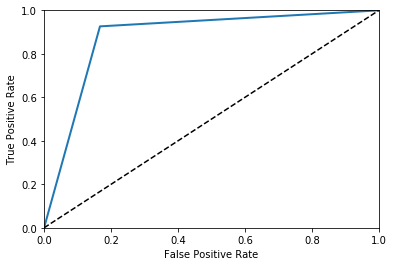

In [34]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
fpr, tpr, thresholds = roc_curve(log_pred, bi_class_res)
print(confusion_matrix(log_pred, bi_class_res), accuracy_score(bi_class_res, log_pred))
print(roc_c)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [24]:
'''OVA -> 81%'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

class OVA_SGD_and_SVM(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ova_sgd_cls = OneVsRestClassifier(SGDClassifier(random_state=42))
        self.svm = LinearSVC(C=1, loss="hinge")

    def fit(self, in_data, fit_data):
        print(in_data, fit_data)
        self.set_results(fit_data)
        self.ova_sgd_cls.fit(in_data, self.four_res)
        ova_pred = self.ova_sgd_cls.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(ova_pred).T), axis=1)
        self.svm.fit(imp_in_data, self.bi_res)
    
    def predict(self, in_data):
        ova_pred = self.ova_sgd_cls.predict(in_data)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(ova_pred).T), axis=1)
        return self.svm.predict(imp_in_data)
    
    def set_results(self, res_data):
        bi_res = []
        for i in range(len(res_data)):
            if res_data[i] == 0 or res_data[i] == 1:
                bi_res.append(0)
            elif res_data[i] == 2 or res_data[i] == 3:
                bi_res.append(1)
        self.bi_res = np.asarray(bi_res)
        self.four_res = res_data.copy()
        print(len(self.bi_res), len(self.four_res))
        
        
res_data = full_results.values
final_res = []
        
for i in range(len(res_data)):
    if res_data[i] == "Pass":
        final_res.append(0)
    elif res_data[i] == "Distinction":
        final_res.append(1)
    elif res_data[i] == "Fail":
        final_res.append(2)
    elif res_data[i] == "Withdrawn":
        final_res.append(3)
                
four_class_res = np.asarray(final_res)
ova_sgd_and_svm = OVA_SGD_and_SVM()
ova_sgd_and_svm.fit(prepared_data, four_class_res)
#prediction = ova_rand_for_cls.predict(prepared_data)
#accuracy_score(bi_class_res, prediction)
#validate_and_scores(ova_sgd_and_svm, prepared_data, bi_class_res, four_class_res)


[[-0.2249208  -0.14275456 -0.15127661 ...  0.          0.
   0.        ]
 [-0.1326969  -0.14275456 -0.15127661 ...  0.          0.
   1.        ]
 [-0.67795421 -0.14275456 -0.15127661 ...  0.          0.
   1.        ]
 ...
 [-0.47034615 -0.14275456 -0.15127661 ...  0.          0.
   0.        ]
 [-0.17779512 -0.14275456 -0.15127661 ...  0.          0.
   0.        ]
 [-0.24804082 -0.14275456 -0.15127661 ...  0.          0.
   0.        ]] [0 2 3 ... 3 0 2]
26074 26074


/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [17]:
'''OVA random forest double binary --> '''
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

class OVA_rand_forest_rand_forest(BaseEstimator, TransformerMixin):
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.ova_ran_for_cls = OneVsRestClassifier(LogisticRegression())#RandomForestClassifier(n_estimators=self.n_estimators))
        self.ran_for_cls = LinearSVC(C=1, loss="hinge")#RandomForestClassifier(n_estimators=self.n_estimators)

    def fit(self, in_data, res_data):
        #print(in_data, res_data)
        org_bi_res, org_four_res = self.set_results(res_data)
        print(org_bi_res)
        self.ova_ran_for_cls.fit(in_data, org_four_res)
        ova_pred = self.ova_ran_for_cls.predict(in_data)
        print(ova_pred)
        bi_ova, four_ova = self.set_results(ova_pred)
        print(bi_ova)
        print(bi_class_res)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(bi_ova).T), axis=1)
        self.ran_for_cls.fit(imp_in_data, org_bi_res)

    
    def predict(self, in_data):
        ova_pred = self.ova_ran_for_cls.predict(in_data)
        bi_ova, four_ova = self.set_results(ova_pred)
        imp_in_data = np.concatenate((in_data, np.atleast_2d(bi_ova).T), axis=1)
        return self.ran_for_cls.predict(imp_in_data)
    
    def set_results(self, res_data):
        bi_res = []
        for i in range(len(res_data)):
            if res_data[i] == 0 or res_data[i] == 1:
                bi_res.append(0)
            elif res_data[i] == 2 or res_data[i] == 3:
                bi_res.append(1)
        return np.asarray(bi_res), res_data.copy()
        #print(len(self.bi_res), len(self.four_res))
        
        
res_data = full_results.values
final_res = []
        
for i in range(len(res_data)):
    if res_data[i] == "Pass":
        final_res.append(0)
    elif res_data[i] == "Distinction":
        final_res.append(1)
    elif res_data[i] == "Fail":
        final_res.append(2)
    elif res_data[i] == "Withdrawn":
        final_res.append(3)
                
four_class_res = np.asarray(final_res)
ova_rand_for_cls = OVA_rand_forest_rand_forest(500)
ova_rand_for_cls.fit(prepared_data, four_class_res)
prediction = ova_rand_for_cls.predict(prepared_data)
accuracy_score(bi_class_res, prediction)
#validate_and_scores(ova_rand_for_cls, prepared_data, four_class_res)


[0 1 1 ... 1 0 1]


/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

[0 3 3 ... 2 0 0]
[0 1 1 ... 1 0 0]
[0 1 1 ... 1 0 1]


0.8356600444887627

In [38]:
'''OVA random forest only -> 12%'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

class OVA_rand_forest_rand_forest(BaseEstimator, TransformerMixin):
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.ova_ran_for_cls = OneVsRestClassifier(RandomForestClassifier(n_estimators=self.n_estimators))

    def fit(self, in_data, res_data):
        bi_res, four_res = self.set_results(res_data)
        self.ova_ran_for_cls.fit(in_data, four_res)
    
    def predict(self, in_data):
        ova_pred = self.ova_ran_for_cls.predict(in_data)
        bi_res, four_res = self.set_results(ova_pred)
        return bi_res
    
    def set_results(self, res_data):
        bi_res = []
        for i in range(len(res_data)):
            if res_data[i] == 0 or res_data[i] == 1:
                bi_res.append(1)
            elif res_data[i] == 2 or res_data[i] == 3:
                bi_res.append(0)
        return np.asarray(bi_res), res_data.copy()
        #print(len(self.bi_res), len(self.four_res))
        
        
res_data = full_results.values
final_res = []
        
for i in range(len(res_data)):
    if res_data[i] == "Pass":
        final_res.append(0)
    elif res_data[i] == "Distinction":
        final_res.append(1)
    elif res_data[i] == "Fail":
        final_res.append(2)
    elif res_data[i] == "Withdrawn":
        final_res.append(3)
                
four_class_res = np.asarray(final_res)
ova_rand_for_cls = OVA_rand_forest_rand_forest(500)
ova_rand_for_cls.fit(prepared_data, four_class_res)
prediction = ova_rand_for_cls.predict(prepared_data)
accuracy_score(bi_class_res, prediction)
validate_and_scores(ova_rand_for_cls, prepared_data, bi_class_res)


Means: Accuracy:  0.47307726249055754 Accuracy_again:  [0.46985734 0.4708319  0.47854102]


In [39]:
from sklearn.metrics import accuracy_score

'''Reduces test output categories to just two - Pass or Fail'''
def classes_to_bin(res_data):
    final_res = []
    for i in range(len(res_data)):
        if res_data[i] == "Pass":
            final_res.append(0)
        elif res_data[i] == "Distinction":
            final_res.append(0)
        elif res_data[i] == "Fail":
            final_res.append(1)
        elif res_data[i] == "Withdrawn":
            final_res.append(1)
    return final_res
            
bi_class_test_res = np.asarray(classes_to_bin(test_results.values.ravel()))
log_reg_and_rand_bi.fit(prepared_data, bi_class_res)
prediction_test = log_reg_and_rand_bi.predict(prepared_test_data)
accuracy_score(bi_class_test_res, prediction_test)

0.8015032980518484

In [10]:
edu_v_res = pd.crosstab(studentInfo_data["final_result"], studentInfo_data["gender"])

edu_v_res_per = pd.DataFrame()

for row in edu_v_res:
    edu_v_res_per[row] = edu_v_res[row]/edu_v_res[row].sum()

edu_v_res_per.style.background_gradient()

,F,M
final_result,,
Distinction,0.094714,0.091189
Fail,0.210830,0.220923
Pass,0.389659,0.370685
Withdrawn,0.304797,0.317203


In [11]:
edu_v_res = pd.crosstab(studentInfo_data["final_result"], studentInfo_data["code_module"])

edu_v_res_per = pd.DataFrame()

for row in edu_v_res:
    edu_v_res_per[row] = edu_v_res[row]/edu_v_res[row].sum()

edu_v_res_per.style.background_gradient()

,AAA,BBB,CCC,DDD,EEE,FFF,GGG
final_result,,,,,,,
Distinction,0.058824,0.085599,0.112314,0.061065,0.121336,0.086318,0.156275
Fail,0.121658,0.223416,0.176139,0.225128,0.191547,0.220433,0.287293
Pass,0.651070,0.389050,0.266125,0.355070,0.441036,0.383664,0.441200
Withdrawn,0.168449,0.301935,0.445422,0.358737,0.246080,0.309585,0.115233


In [12]:
edu_v_res = pd.crosstab(studentInfo_data["final_result"], studentInfo_data["num_of_prev_attempts"])

edu_v_res_per = pd.DataFrame()

for row in edu_v_res:
    edu_v_res_per[row] = edu_v_res[row]/edu_v_res[row].sum()

edu_v_res_per.style.background_gradient()

,0,1,2,3,4,5,6
final_result,,,,,,,
Distinction,0.100524,0.043346,0.032593,0.007042,0.000000,0.000000,0.250000
Fail,0.201647,0.305850,0.349630,0.401408,0.307692,0.461538,0.250000
Pass,0.392245,0.302213,0.251852,0.218310,0.333333,0.153846,0.000000
Withdrawn,0.305584,0.348590,0.365926,0.373239,0.358974,0.384615,0.500000


In [13]:
edu_v_res = pd.crosstab(studentInfo_data["final_result"], studentInfo_data["region"])

edu_v_res_per = pd.DataFrame()

for row in edu_v_res:
    edu_v_res_per[row] = edu_v_res[row]/edu_v_res[row].sum()

edu_v_res_per.style.background_gradient()

,East Anglian Region,East Midlands Region,Ireland,London Region,North Region,North Western Region,Scotland,South East Region,South Region,South West Region,Wales,West Midlands Region,Yorkshire Region
final_result,,,,,,,,,,,,,
Distinction,0.097904,0.084567,0.082770,0.081779,0.126166,0.073297,0.095183,0.115585,0.107697,0.108374,0.084851,0.070488,0.082253
Fail,0.208982,0.195349,0.220439,0.231343,0.179375,0.242257,0.247243,0.177641,0.175938,0.190887,0.297220,0.213400,0.223829
Pass,0.391916,0.372516,0.466216,0.341729,0.379046,0.328630,0.394370,0.399337,0.416235,0.389573,0.366731,0.362510,0.366401
Withdrawn,0.301198,0.347569,0.230574,0.345149,0.315414,0.355816,0.263204,0.307437,0.300129,0.311166,0.251198,0.353602,0.327517


In [61]:
edu_v_res = pd.crosstab(studentInfo_data["final_result"], studentInfo_data["imd_band"])

edu_v_res_per = pd.DataFrame()

for row in edu_v_res:
    edu_v_res_per[row] = edu_v_res[row]/edu_v_res[row].sum()

edu_v_res_per.style.background_gradient()

,0-10%,10-20,20-30%,30-40%,40-50%,50-60%,60-70%,70-80%,80-90%,90-100%
final_result,,,,,,,,,,
Distinction,0.050740,0.054323,0.071976,0.089008,0.089988,0.095070,0.102926,0.108718,0.118755,0.141167
Fail,0.276654,0.259386,0.230980,0.221532,0.214066,0.224392,0.185198,0.208058,0.179218,0.166009
Pass,0.300815,0.331911,0.335523,0.380051,0.375921,0.392766,0.416179,0.406391,0.421796,0.434148
Withdrawn,0.371791,0.354380,0.361522,0.309409,0.320025,0.287772,0.295697,0.276832,0.280232,0.258675


In [15]:
ass_data = load_assessments_data()
ass_data

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0
...,...,...,...,...,...,...
201,GGG,2014J,37443,CMA,229.0,0.0
202,GGG,2014J,37435,TMA,61.0,0.0
203,GGG,2014J,37436,TMA,124.0,0.0
204,GGG,2014J,37437,TMA,173.0,0.0


In [16]:
stu_asse_data = load_studentAssessment_data()
stu_asse_data.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [17]:
vle_data = load_vle_data()
vle_data.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


In [18]:
vle_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+ KB


In [19]:
student_vle_data = load_studentVle_data()
student_vle_data.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


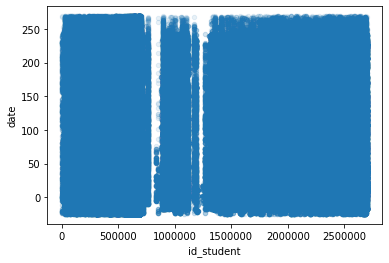

In [20]:
student_vle_data.plot(kind="scatter", x="id_student", y="date", alpha=0.1)

In [21]:
ass_data.head()
courses_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes


In [22]:
ass_type_vs_module = pd.crosstab(ass_data["assessment_type"], ass_data["code_module"])
ass_type_vs_module


code_module,AAA,BBB,CCC,DDD,EEE,FFF,GGG
assessment_type,,,,,,,
CMA,0,15,8,7,0,28,18
Exam,2,4,4,4,3,4,3
TMA,10,23,8,24,12,20,9


In [23]:
ass_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


In [24]:
student_vle_derived = pd.DataFrame(columns = ["id_student", "code_module", "code_presentation", "all_clicks", "all_sites", "avg_time"])

for index, mod in studentInfo_train.iterrows():
    stu_tbl = student_vle_data.loc[student_vle_data["id_student"] == mod["id_student"]]
    stu_tbl = stu_tbl.loc[stu_tbl["code_module"] == mod["code_module"]]
    stu_tbl = stu_tbl.loc[stu_tbl["code_presentation"] == mod["code_presentation"]]
    ord_stu = stu_tbl.sort_values(by="date")
    avg_dif = ord_stu["date"].diff().mean()
    total_clicks = stu_tbl["sum_click"].sum()
    if np.isnan(avg_dif):
        avg_dif = courses_data.loc[(courses_data['code_module'] == mod["code_module"]) & (courses_data['code_presentation'] == mod["code_presentation"])]
        avg_dif = avg_dif.reset_index().at[0,"module_presentation_length"]
    all_der = pd.DataFrame(data={"id_student": [mod["id_student"]], "code_module": [mod["code_module"]], "code_presentation": [mod["code_presentation"]], "all_clicks": [total_clicks], "all_sites": [len(stu_tbl.drop_duplicates(subset="id_site", keep="first"))], "avg_time": [avg_dif]})
    student_vle_derived = pd.concat([student_vle_derived,  all_der], ignore_index=True)
#student_vle_derived = student_vle_derived.drop_duplicates(subset="id_student", keep="first")
student_vle_derived
studentInfo_train.loc[studentInfo_train["id_student"] == 636749]

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
28600,FFF,2014J,636749,F,Yorkshire Region,Lower Than A Level,10-20,0-35,0,240,Y,Withdrawn


In [25]:
info_and_vle = pd.merge(studentInfo_train, student_vle_derived, on=['id_student', 'code_module', 'code_presentation'], how='outer')

info_and_vle

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,all_clicks,all_sites,avg_time
0,EEE,2013J,581914,M,Scotland,HE Qualification,0-10%,0-35,0,90,N,Pass,957,48,1.178404
1,DDD,2014J,632314,F,East Anglian Region,A Level or Equivalent,30-40%,0-35,1,120,Y,Fail,584,48,1.281818
2,AAA,2013J,334333,F,South West Region,A Level or Equivalent,0-10%,0-35,0,240,Y,Withdrawn,303,23,0.737374
3,FFF,2014J,636749,F,Yorkshire Region,Lower Than A Level,10-20,0-35,0,240,Y,Withdrawn,0,0,269.000000
4,CCC,2014J,2469688,M,London Region,A Level or Equivalent,10-20,0-35,0,60,N,Pass,886,91,0.662437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26069,FFF,2013J,591219,M,Yorkshire Region,A Level or Equivalent,10-20,0-35,0,60,N,Pass,1736,100,0.815710
26070,FFF,2014J,679688,M,Ireland,Lower Than A Level,50-60%,35-55,0,60,N,Withdrawn,745,59,0.165992
26071,BBB,2013B,447790,F,North Western Region,Lower Than A Level,0-10%,0-35,1,60,N,Withdrawn,204,41,1.263736
26072,CCC,2014J,607668,F,Wales,A Level or Equivalent,90-100%,0-35,0,120,N,Pass,1516,78,0.642680


In [26]:
module_data = pd.DataFrame(columns=["code_module", "code_presentation", "per_TMA"])

for index, mod in courses_data.iterrows():
    mod_ass = ass_data.loc[mod["code_module"] == ass_data["code_module"]]
    mod_ass = mod_ass.loc[mod["code_presentation"] == mod_ass["code_presentation"]]
    tma = mod_ass.loc["TMA" == mod_ass["assessment_type"]]["weight"].sum()
    all_der = pd.DataFrame(data={"code_module": [mod["code_module"]], "code_presentation": [mod["code_presentation"]], "per_TMA": [tma]})
    module_data = pd.concat([module_data, all_der], ignore_index=True)

all_student = pd.merge(info_and_vle, module_data, on=['code_module', 'code_presentation'], how='outer')
all_student.head(16000)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,all_clicks,all_sites,avg_time,per_TMA
0,EEE,2013J,581914,M,Scotland,HE Qualification,0-10%,0-35,0,90,N,Pass,957,48,1.178404,100.0
1,EEE,2013J,572154,M,Scotland,HE Qualification,40-50%,0-35,0,150,N,Withdrawn,1224,40,0.286533,100.0
2,EEE,2013J,606190,M,East Midlands Region,Lower Than A Level,30-40%,35-55,0,60,N,Withdrawn,1,1,268.000000,100.0
3,EEE,2013J,485909,M,East Midlands Region,A Level or Equivalent,20-30%,0-35,0,60,N,Pass,682,33,1.205882,100.0
4,EEE,2013J,140060,M,West Midlands Region,A Level or Equivalent,90-100%,35-55,0,50,N,Distinction,2110,59,0.522267,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,BBB,2013J,608497,F,South East Region,Lower Than A Level,30-40%,0-35,0,60,N,Withdrawn,110,19,1.065217,95.0
15996,BBB,2013J,586720,M,London Region,Lower Than A Level,40-50%,0-35,0,120,N,Fail,59,6,3.724138,95.0
15997,BBB,2013J,504022,F,North Region,A Level or Equivalent,0-10%,0-35,1,120,N,Pass,81,11,3.926829,95.0
15998,BBB,2013J,504842,F,East Midlands Region,Lower Than A Level,20-30%,0-35,0,60,N,Withdrawn,0,0,268.000000,95.0


In [27]:
student_per_pres = pd.DataFrame(columns = ["code_module", "code_presentation", "no_students"])
# Reduce to table that only contains sites not visited by everyone in a presentation but visited frequently by those that do visit them
# Frequently being more than 6 times
# First find number of students per presentation
for index, mod in courses_data.iterrows():
    mod_ass = studentInfo_data.loc[mod["code_module"] == studentInfo_data["code_module"]]
    mod_ass = mod_ass.loc[mod["code_presentation"] == mod_ass["code_presentation"]]
    all_der = pd.DataFrame(data={"code_module": [mod["code_module"]], "code_presentation": [mod["code_presentation"]], "no_students": [len(mod_ass)]})
    student_per_pres = pd.concat([student_per_pres, all_der], ignore_index=True)
student_per_pres


,code_module,code_presentation,no_students
0,AAA,2013J,383
1,AAA,2014J,365
2,BBB,2013J,2237
3,BBB,2014J,2292
4,BBB,2013B,1767
5,BBB,2014B,1613
6,CCC,2014J,2498
7,CCC,2014B,1936
8,DDD,2013J,1938
9,DDD,2014J,1803


In [28]:
avg_student_per_pers = student_per_pres["no_students"].mean()

In [29]:
# Want to get sites visited by less than 1482 different students and then pick the most visited(including same students)
relevant_sites = pd.DataFrame(columns=["id_site", "num_students", "clicks_per_site"])

for index, mod in vle_data.iterrows():
    mod_vle = student_vle_data.loc[mod["id_site"] == student_vle_data["id_site"]]
    num_clicks = mod_vle["sum_click"].sum()
    mod_vle = mod_vle.drop_duplicates(["id_student", "code_module", "code_presentation"], keep="first")
    if len(mod_vle) < avg_student_per_pers and num_clicks>1000:
        all_der = pd.DataFrame(data={"id_site": [mod["id_site"]], "num_students": [len(mod_vle)], "clicks_per_site": num_clicks})
        relevant_sites = pd.concat([relevant_sites, all_der], ignore_index = True)

relevant_sites = relevant_sites.sort_values(by="clicks_per_site", ascending=False)

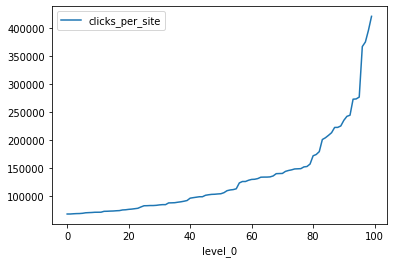

In [30]:
relevant_sites = relevant_sites.head(100)
relevant_sites = relevant_sites.sort_values(by="clicks_per_site", ascending=True)
relevant_sites.reset_index().reset_index().plot(x='level_0', y='clicks_per_site')

In [31]:
relevant_sites.tail(20)

,id_site,num_students,clicks_per_site
397,729789,1398,172244
1288,527114,1354,174525
1165,832567,942,179633
276,768351,1290,201239
1387,716432,1361,204379
1017,551012,845,208700
173,542811,1415,213383
1578,779075,1272,222821
1765,882676,1395,222873
262,768348,861,225426


In [32]:
site_names = [site for site in relevant_sites.tail(20)["id_site"]]
most_popular_sites = pd.DataFrame(columns=["id_student", "code_module", "code_presentation"]+site_names)

for index, stu in studentInfo_train.iterrows():
    stu_data = studentVle_data.loc[studentVle_data["id_student"] == stu["id_student"]]
    stu_sites = stu_data.loc[(stu_data["code_module"] == stu["code_module"])&(stu_data["code_presentation"] == stu["code_presentation"])]
    site_data = {site: [stu_sites.loc[stu_sites["id_site"] == site]["sum_click"].sum()] for site in site_names}
    site_data["id_student"], site_data["code_module"]= [stu["id_student"]], [stu["code_module"]]
    site_data["code_presentation"] = [stu["code_presentation"]]
    #print(site_data)
    all_der = pd.DataFrame(data = site_data)
    most_popular_sites = pd.concat([most_popular_sites, all_der], ignore_index=True)
    
most_popular_sites.head(3000)


,id_student,code_module,code_presentation,729789,527114,832567,768351,716432,551012,542811,...,772705,547272,551010,703732,832565,813708,526738,547303,779089,542807
0,581914,EEE,2013J,0,0,0,0,0,34,0,...,0,0,152,0,0,0,0,0,0,0
1,632314,DDD,2014J,0,0,0,0,0,0,0,...,0,0,0,0,0,61,0,0,0,0
2,334333,AAA,2013J,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,636749,FFF,2014J,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2469688,CCC,2014J,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,527744,FFF,2014B,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,37,0
2996,696430,DDD,2014J,0,0,0,0,0,0,0,...,0,0,0,0,0,27,0,0,0,0
2997,676128,FFF,2014J,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2998,286402,BBB,2013J,0,0,0,0,0,0,0,...,0,0,0,64,0,0,0,0,0,0


In [114]:
full_data = pd.merge(all_student, most_popular_sites, on=['id_student', 'code_module', 'code_presentation'], how='outer')
full_data = pd.merge(full_data, courses_data, on = ['code_module', 'code_presentation'], how='outer')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26074 entries, 0 to 26073
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 26074 non-null  object 
 1   code_presentation           26074 non-null  object 
 2   id_student                  26074 non-null  object 
 3   gender                      26074 non-null  object 
 4   region                      26074 non-null  object 
 5   highest_education           26074 non-null  object 
 6   imd_band                    25166 non-null  object 
 7   age_band                    26074 non-null  object 
 8   num_of_prev_attempts        26074 non-null  int64  
 9   studied_credits             26074 non-null  int64  
 10  disability                  26074 non-null  object 
 11  final_result                26074 non-null  object 
 12  all_clicks                  26074 non-null  object 
 13  all_sites                   260

In [64]:
full_data["all_clicks"] = full_data["all_clicks"].astype(str).astype(int)
full_data["all_sites"] = full_data["all_sites"].astype(str).astype(int)

KeyError: 'all_clicks'

In [63]:
corr_mat = full_data.corr(method="kendall")
corr_mat#["final_result"]


,id_student,num_of_prev_attempts,studied_credits
id_student,1.000000,-0.160279,-0.046423
num_of_prev_attempts,-0.160279,1.000000,0.170045
studied_credits,-0.046423,0.170045,1.000000


In [61]:
edu_v_res = pd.crosstab(studentInfo_train["final_result"], studentInfo_train["highest_education"])

edu_v_res_per = pd.DataFrame()

for row in edu_v_res:
    edu_v_res_per[row] = edu_v_res[row]/edu_v_res[row].sum()

edu_v_res_per.style.background_gradient()

,A Level or Equivalent,HE Qualification,Lower Than A Level,No Formal quals,Post Graduate Qualification
final_result,,,,,
Distinction,0.108669,0.141913,0.054722,0.043165,0.280000
Fail,0.193040,0.165169,0.261828,0.273381,0.108000
Pass,0.412958,0.422040,0.334410,0.230216,0.392000
Withdrawn,0.285333,0.270877,0.349040,0.453237,0.220000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6daf87e810>,
      dtype=object)

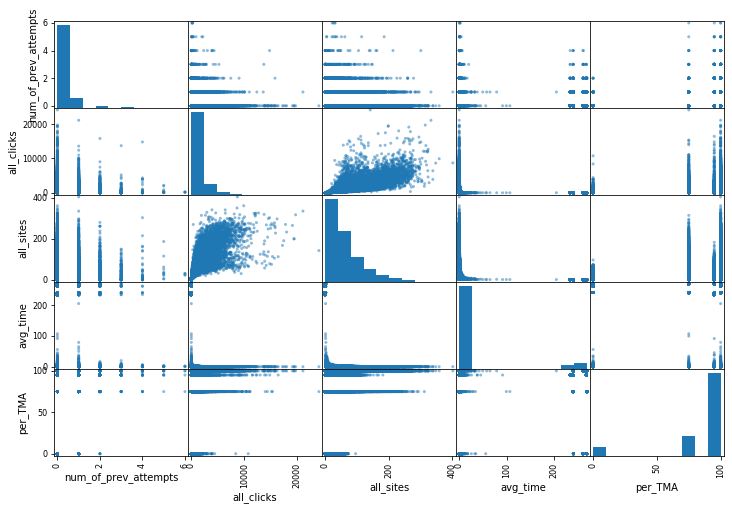

In [67]:
from pandas.plotting import scatter_matrix
attributes = ["num_of_prev_attempts", "all_clicks", "all_sites", "avg_time", "per_TMA", "final_result"]
scatter_matrix(full_data[attributes], figsize=(12, 8))

In [116]:
missing_imd = full_data.isnull().any(axis=1)
imd_ranks = ["{}-{}%".format(x, x+10) for x in range(0, 100, 10)]
ranks_to_int = dict(zip(imd_ranks, range(len(imd_ranks))))
full_data["imd_band_rank"] = full_data["imd_band"].map(ranks_to_int)
imd_medians = {}


for index, stu in full_data[missing_imd].iterrows():
    if stu["region"] not in imd_medians.keys():
        region = full_data.loc[full_data["region"] == stu["region"]].dropna()
        region_ranked = region.sort_values(['imd_band_rank'])
        full_data["imd_band"][index] = region_ranked.reset_index()["imd_band"][len(region_ranked)//2]
        imd_medians[stu["region"]] = full_data["imd_band"][index]
    else:
        full_data["imd_band"][index] = imd_medians[stu["region"]]
print(imd_medians)
full_data[missing_imd]


/home/josephjenner-bailey/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/josephjenner-bailey/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


{'North Region': '30-40%', 'Ireland': '50-60%', 'South Region': '70-80%', 'West Midlands Region': '40-50%', 'North Western Region': '30-40%', 'Scotland': '50-60%', 'Yorkshire Region': '40-50%', 'South West Region': '50-60%'}


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,551010,703732,832565,813708,526738,547303,779089,542807,module_presentation_length,imd_band_rank
51,EEE,2013J,2389754,M,North Region,HE Qualification,30-40%,35-55,0,60,...,257,0,0,0,0,0,0,0,268,NaN
62,EEE,2013J,555228,M,North Region,A Level or Equivalent,30-40%,0-35,0,60,...,379,0,0,0,0,0,0,0,268,NaN
201,EEE,2013J,2418732,F,North Region,HE Qualification,30-40%,35-55,0,60,...,528,0,0,0,0,0,0,0,268,NaN
234,EEE,2013J,608459,M,North Region,Lower Than A Level,30-40%,0-35,0,90,...,121,0,0,0,0,0,0,0,268,NaN
239,EEE,2013J,604378,F,North Region,HE Qualification,30-40%,0-35,0,30,...,146,0,0,0,0,0,0,0,268,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25994,EEE,2014J,699142,M,North Region,HE Qualification,30-40%,35-55,0,30,...,0,0,107,0,0,0,0,0,269,NaN
25996,EEE,2014J,627312,M,North Region,HE Qualification,30-40%,35-55,1,60,...,0,0,180,0,0,0,0,0,269,NaN
26035,EEE,2014J,688451,M,North Region,Post Graduate Qualification,30-40%,0-35,0,60,...,0,0,458,0,0,0,0,0,269,NaN
26038,EEE,2014J,686058,F,North Region,Lower Than A Level,30-40%,35-55,0,120,...,0,0,471,0,0,0,0,0,269,NaN


In [121]:
full_data = full_data.drop("imd_band_rank", axis=1)

In [123]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
region_1hot = encoder.fit_transform(full_data["region"])
region_1hot

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [82]:
imd_rank

['0-10%',
 '10-20%',
 '20-30%',
 '30-40%',
 '40-50%',
 '50-60%',
 '60-70%',
 '70-80%',
 '80-90%',
 '90-100%']

In [87]:
5%2


1